A data analysis report by Giuseppe Di Bernardo

# Introduction

Almost half a million taxi trips are made daily in the city that never sleeps, producing a plethora of information
that can prove useful for both the passengers and drivers. We choose to understand what features (besides the quality
of the driver) actually factors into the tip received by a cab driver.  Originally the ultimate goal of this project was to predict the amount a taxi driver will be tipped based on a number of different features pertaining to the trip. As we were working on the model for tips we realized that the driver would not know things like *pickup location*, *dropoff location*, or time offhand just to discover what he "might" be tipped.  Among the factors driving the typical passengers to pay higher tips or lower tips, we wanted to answer the following question: **Are there some areas in NYC, traveling from which people pay more tips?**  After examining quite an extensive data set, we have come up with the following observations.

# Exploring the Data Set 

## Preparing the notebook

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline
% config InlineBackend.figure_format='retina'

In [2]:
# import relevant modules 
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

sns.set(font='sans')

## Reading the input file

In [3]:
# dir paths 
data_dir = ("../data/")
csv = "yellow_tripdata_2015-06.csv"
fullcsv = data_dir + csv
os.path.normpath(fullcsv)
# print(fullcsv)

'../data/yellow_tripdata_2015-06.csv'

The data provided to the *NYC Taxi and Limousine Commission (TLC)* - by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP) - are stored in `CSV` format, and organized by year and month. In each file, each row represents a single taxi trip.  
Let's take a look to the data. To this purpose, we will use `pandas` to do all the big data clean up and preparation. Each row of the `yellow_tripdata_.csv file` represents a trip, and the columns are the attributes for these trips. 

In [4]:
# Create a pandas dataframe from the location data set. 
# Load the location data set and, parse the dates so 
# they're no longer strings but now rather Python datetime objects
# this lets us do date and time based operations on the data set
# our data frame
df = pd.read_csv(fullcsv, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [5]:
# uncomment this if you want to get insights of the data types you are dealing with
# df.info() 

In [6]:
# a first glimpse: the first five trips of the file 
df.head() 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30
2,2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,-73.978111,40.738434,1,N,-73.990273,40.745438,1,8.0,0.0,0.5,2.20,0.0,0.3,11.00
3,2,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,-73.945892,40.773529,1,N,-73.971527,40.760330,1,13.5,0.0,0.5,2.86,0.0,0.3,17.16
4,1,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,-73.979088,40.776772,1,N,-73.982162,40.758999,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30


In [7]:
databegin = len(df)
print("We have " +str(databegin)+" trips in New York in June 2015")

# a double-check
# df.count(axis=0, level=None, numeric_only=False)  

We have 12324935 trips in New York in June 2015


In [8]:
# check it out if times are converted to datetime objects
df.tpep_pickup_datetime.head()
# df['tpep_pickup_datetime'].head()

0   2015-06-02 11:19:29
1   2015-06-02 11:19:30
2   2015-06-02 11:19:31
3   2015-06-02 11:19:31
4   2015-06-02 11:19:32
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [9]:
Timedelta = df.tpep_pickup_datetime.iloc[-1] - df.tpep_pickup_datetime.iloc[0]
print("We have " +str(Timedelta)+" of data observation for trips in New York in June 2015")

We have 28 days 10:34:53 of data observation for trips in New York in June 2015


Trip data looks like this. The file relative to the month of June has about ** 12 million rows **,  and each row contains: `vendor id`, `rate code`, `store and forward flag`, `pickup date/time dropoff date/time`, `passenger count`, `trip distance`, and `latitude/longitude` coordinates for the pickup and dropoff locations.  The possibilities are endless! I smell a tip analysis coming on :-) 

## Exploratory data analysis

The data set is organized as follows:

* `VendorID`:  e.g., *Verifone Transportation Systems* (VTS), or *Mobile Knowledge Systems Inc* (CMT), implemented as part of the Technology Passenger Enhancements Project.
* `tpep_pickup_datetime`: start time of the trip, `mm-dd-yyyy hh24:mm:ss` EDT.
* `tpep_dropoff_datetime`: end time of the trip, `mm-dd-yyyy hh24:mm:ss` EDT. 
* `RateCodeID`: taximeter rate, see NYCT&L description.
* `store_and_fwd_flag`: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip
* `passenger_count`: number of passengers on the trip, default value is one.
* `trip_distance`: trip distance measured by the taximeter in miles.
* `pickup_longitude` and `pickup_latitude`: GPS coordinates at the start of the trip.
* `dropoff_longitude` and `dropoff_latitude`: GPS coordinates at the end of the trip.
* `payment_type`: A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip
* `fare_amount`: The time-and-distance fare calculated by the meter	
* `extra`: Miscellaneous extras and surcharges. Currently, this only includes the `$0.50` and `$1` rush hour and overnight charges.
* `mta_tax`: `$0.50` MTA tax that is automatically triggered based on the metered rate in use.	
* `tip_amount`: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
* `tolls_amount`: Total amount of all tolls paid in trip. 
* `improvement_surcharge`: `$0.30` improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in `2015`. 	
* `total_amount`: The total amount charged to passengers. Does not include cash tips.


A dictionary for the yellow taxi trip records can be found [here](http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf). 

Let's use the `replace` method to modify a subset of values in an object. `replace` provides a simpler and more flexible way to do so.

In [10]:
# the argument is passed as a dict: 
df.VendorID = df.VendorID.replace({1: 'CMT', 2: 'VFI'})
df.RateCodeID = df.RateCodeID.replace({1: 'STD', 2: 'JFK',\
                                       3: 'NEW', 4: 'NOW',\
                                       5: 'NEG', 6: 'GRP'})
df.payment_type = df.payment_type.replace({1: 'CRD', 2: 'CSH',\
                                           3: 'NOC', 4: 'DIS',\
                                           5: 'UNK', 6: 'VOI'})

It is convenient to visualize some of these attributes, e.g., the `payment_type`, to get first insights in the distributions of these data values: 

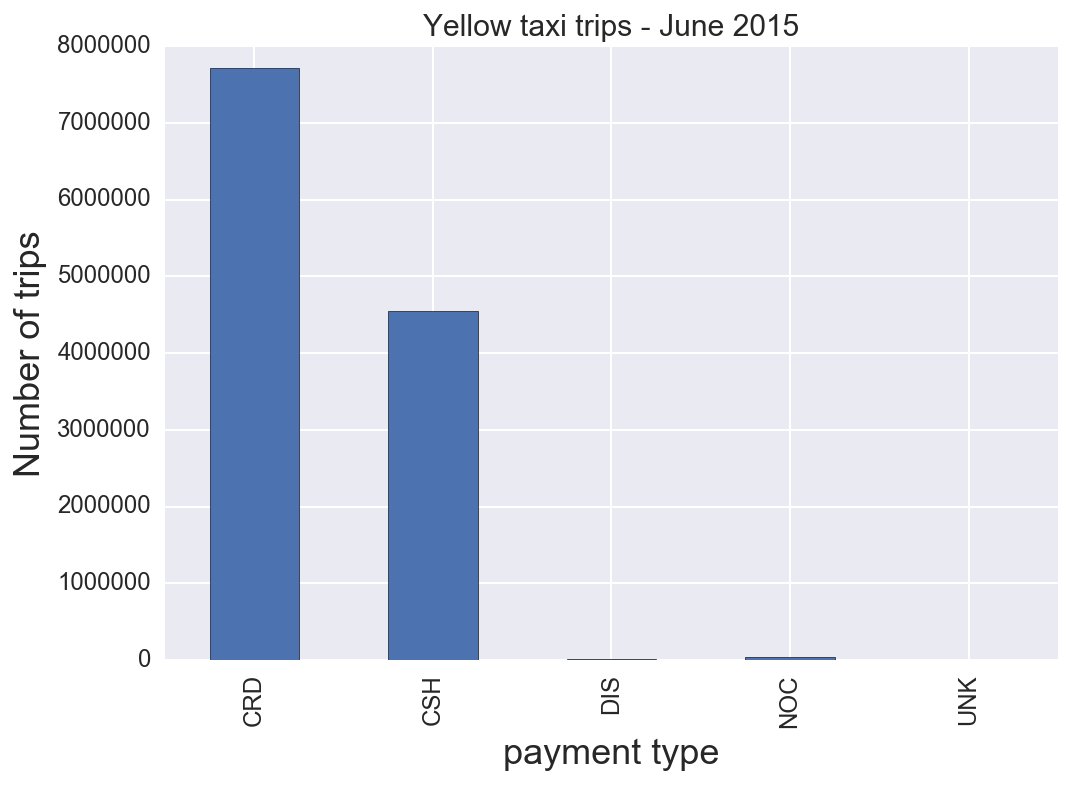

In [11]:
ax = df.groupby(df['payment_type']).size().plot(kind='bar')

ax.set_xlabel('payment type', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
plt.title('Yellow taxi trips - June 2015', fontsize=15)
ax.tick_params(labelsize=12)

We can see that **credit card and cash** are the taxi's main payment types. The rows with the other strange values can be  deleted. By doing this (we are going to do the same with the other attributes too) we are adding a bit of bias to the predictions, but those values are so unusual that will hardly affect to the prediction's performance.  

In [12]:
# we are going to drop trips with payment not cash or credit
# types = ['CRD','CSH']
# df = df[df.payment_type.isin(types)]
payment_type = ((df.payment_type == 'CRD') | (df.payment_type == 'CSH'))

As the rest of the attributes are numeric, a way to help ourselves is by obtaining a few of statistical values from them. 

In [13]:
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07,1.232494e+07
mean,1.681898e+00,1.182908e+01,-7.291385e+01,4.016687e+01,-7.294474e+01,4.018478e+01,1.320408e+01,3.234049e-01,4.976184e-01,1.736538e+00,3.161518e-01,2.997213e-01,1.637827e+01
std,1.335180e+00,7.678550e+03,8.796762e+00,4.843162e+00,8.669562e+00,4.777574e+00,1.060766e+02,4.804153e-01,4.214822e-02,2.637613e+00,1.542573e+00,1.216386e-02,1.063828e+02
min,0.000000e+00,0.000000e+00,-7.592333e+02,-6.713696e+01,-7.541667e+02,-1.617787e+01,-3.000000e+02,-3.050000e+01,-5.000000e-01,-8.000000e+01,-1.400000e+01,-3.000000e-01,-3.000000e+02
25%,1.000000e+00,1.010000e+00,-7.399190e+01,4.073614e+01,-7.399130e+01,4.073463e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,1.000000e+00,1.750000e+00,-7.398154e+01,4.075323e+01,-7.397962e+01,4.075380e+01,9.500000e+00,0.000000e+00,5.000000e-01,1.160000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,3.230000e+00,-7.396646e+01,4.076793e+01,-7.396248e+01,4.076879e+01,1.500000e+01,5.000000e-01,5.000000e-01,2.350000e+00,0.000000e+00,3.000000e-01,1.830000e+01
max,9.000000e+00,1.008332e+07,1.490285e+02,6.970258e+01,1.255356e+02,4.834500e+02,3.354137e+05,6.524200e+02,6.035000e+01,9.809100e+02,9.009700e+02,7.000000e-01,3.354145e+05


Concerning the `fare_amount`, this is an attribute that can be difficult to properly visualize. So, we can have a look to the above table. What we immediately observe is that there are negative values!  We may thinking of a range of ordinary values for this attribute, something like between `$3.00` and `$200.00`

In [14]:
fare_amount = ((df.fare_amount  >=3.0 ) & (df.fare_amount <=200.0))

From the dictionary above, concerning the attribute `improvement_surcharge` it is straightforward to save only trips with `$0.3` value. The same idea applies to the `mta_tax`: 

In [15]:
surcharge = (df.improvement_surcharge  == 0.3)
mta_tax = (df.mta_tax == 0.5)

An useful representation from `tolls_amount` is very difficult because of the huge range of values. 
A possible reason of that is that drivers manually introduced them. 
Also, these values can change as the course of the time, so they probably aren't going to be same 
in all the month. A solution for that might be to obtain the values that are repeated, for example, 
more that a thousand times:

In [16]:
tolls = df.groupby(['tolls_amount']).size()

print(tolls[tolls >= 1000.00])
tolls = None

tolls_amount
0.00     11667901
2.54         5046
5.33         3170
5.54       609922
8.00         1059
9.75         7211
11.08        3433
11.75        9259
17.29        1099
dtype: int64


Therefore, a good range for this attribute could be something like `$0.00` and `$30.00`

In [17]:
# Uncomment, and check it out by yourself!
# ax = df.groupby(df['tolls_amount']).size().plot(kind='bar')

# ax.set_xlabel('tolls amount', fontsize=18)
# ax.set_ylabel('Number of trips', fontsize=18)
# plt.title('Yellow taxi trips - June 2015')
# ax.tick_params(labelsize=12)

In [18]:
tolls_amount = ((df.tolls_amount >=0.0) & (df.tolls_amount <=30.0))

Regarding the `tip_amount`, as suspected, we notice that most cash fares have a tip of `$0`, which seems odd.

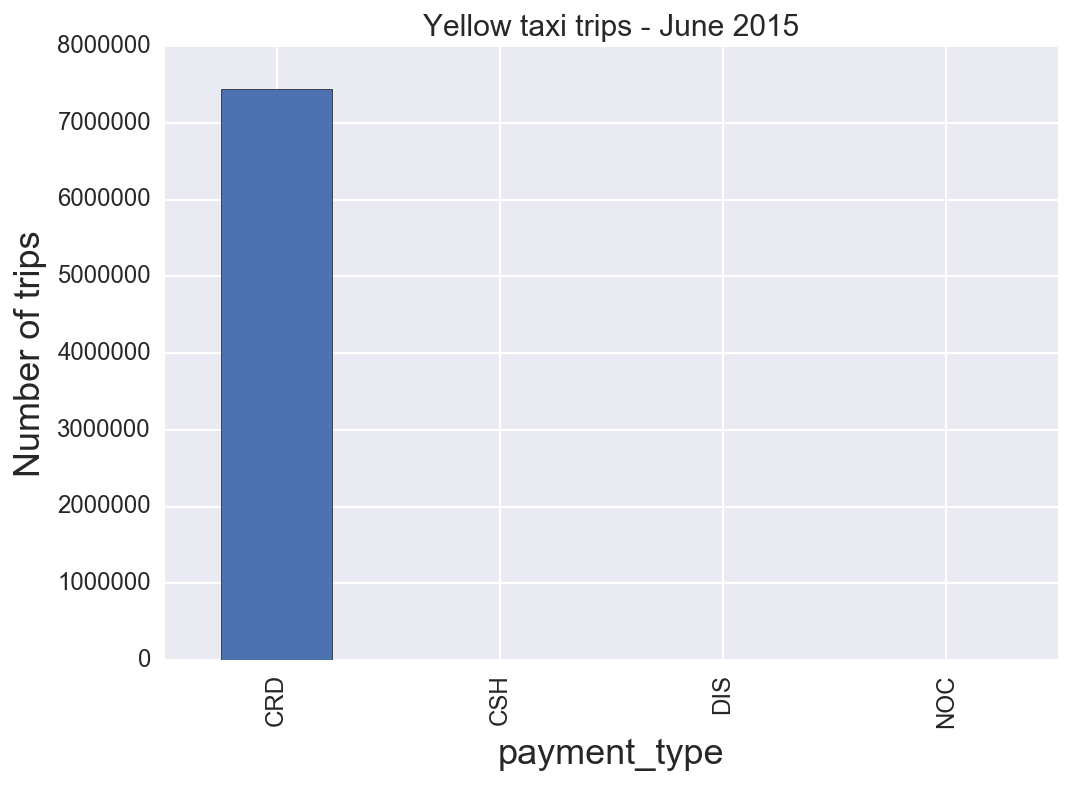

In [19]:
ax = df[df['tip_amount'] > 0].groupby(['payment_type']).size().plot(kind = 'bar')

ax.set_xlabel('payment_type', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
plt.title('Yellow taxi trips - June 2015', fontsize=15)
ax.tick_params(labelsize=12)

A possible explanation is that it's very possible drivers are under-reporting cash tips, in order to pocket all of the cash themselves, which obviously skews our data quite a bit. So, we remove this annoying noise, deleting the `CSH payment type`. Moreover, it seems reasonable to assume an upper limit of a value of `$100.00`. Also, we drop unnecessary columns: 

In [20]:
tip_amount   = ((df.tip_amount >=0.0) & (df.tip_amount <=100.0))

df = df[payment_type & fare_amount & surcharge & mta_tax & tip_amount & tolls_amount]
payment_type = None 
surcharge = None 
fare_amount = None 
mta_tax = None 
tip_amount = None 
tolls_amount = None 

# drop unnecessary columns
df.drop(['VendorID','RateCodeID','store_and_fwd_flag'], axis=1, inplace=True)

## Cleaning the Data Set
**We need to remove the noise: some bad data with 0 km trips, impossible gps coordinates and so on...**

In an effort to determine trends in our data, in the next we add and reformat a number of columns to our dataframe for features that we thought might be interesting to predict or might be valuable as explanatory factors in predicting other features, such as:

* trip time in seconds
* trip time in minutes
* trip time in hours
* time of day (minutes since midnight)
* hour of the trip
* time of day (morning, afternoon, etc.)
* speed of trip (mph)
* day of the week
* month of the year
* cost of trip (total cost minus tip)
* percent tip (tip/cost)

In [21]:
trip_time = df.tpep_dropoff_datetime - df.tpep_pickup_datetime 
# ATTENTION, this in timedelta64[ns].
# we need to convert it in either in seconds or minutes or in hours, as you prefer

In [22]:
# generate a column for trip time in secs
trip_time_in_secs = (trip_time / np.timedelta64(1,'s'))
# generate a column for trip time in minutes
trip_time_in_mins = (trip_time / np.timedelta64(1,'m'))
# generate a column for trip time in hours
trip_time_in_hours = (trip_time / np.timedelta64(1,'h'))

In [23]:
df['trip_time_in_secs'] = trip_time_in_secs
df['trip_time_in_mins'] = trip_time_in_mins
df['trip_time_in_hours'] = trip_time_in_hours

In [24]:
# generate column for minutes since midnight
df['time'] = [a.hour*60 + a.minute for a in df['tpep_pickup_datetime']]

# generate a column for hour of the day
df['hour'] = [a.hour for a in df['tpep_pickup_datetime']]

# create a column for time of day
df['time_of_day'] = ['morning' if (4 <= time.hour < 12) else 'afternoon' \
                     if (12 <= time.hour < 17) else 'evening' \
                     if (17 <= time.hour < 21) else 'night' \
                     for time in df['tpep_pickup_datetime']]

# generate a column for average speed of the trip
# speed in mph
df['speed'] = df['trip_distance']/df['trip_time_in_hours']

# generate a column for the day of the week
df['weekday'] = [a.weekday() for a in df['tpep_pickup_datetime']]

# generate a column to note whether it was a weekday or a weekend
df['weekend'] = [1 if (a == 5 or a == 6) else 0 for a in df['weekday']]

For obtaining a better value to predict, we can obtain a normalized version of the tip, the *tip percentage*.

In [25]:
# Let's create a new column for the percentage tip
subtotal = df['fare_amount'] + df['improvement_surcharge'] + df['mta_tax']
tip = df['tip_amount'] / subtotal
df['percent_tip'] = tip
# quick look to the statistical values of the new attributes 
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tip_amount,...,total_amount,trip_time_in_secs,trip_time_in_mins,trip_time_in_hours,time,hour,speed,weekday,weekend,percent_tip
count,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,12179403.0,1.217940e+07,...,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.217940e+07,1.216834e+07,1.217940e+07,1.217940e+07,1.217940e+07
mean,1.684904e+00,1.190353e+01,-7.296954e+01,4.019754e+01,-7.301799e+01,4.022535e+01,1.300450e+01,3.243358e-01,0.5,1.717273e+00,...,1.613569e+01,9.284446e+02,1.547408e+01,2.579013e-01,8.406718e+02,1.351895e+01,inf,2.862231e+00,2.623808e-01,1.219843e-01
std,1.338139e+00,7.724249e+03,8.566717e+00,4.716323e+00,8.359076e+00,4.606647e+00,1.024602e+01,3.646322e-01,0.0,2.362776e+00,...,1.266982e+01,2.348429e+03,3.914049e+01,6.523415e-01,3.918612e+02,6.524385e+00,NaN,1.989610e+00,4.399285e-01,1.219505e-01
min,0.000000e+00,0.000000e+00,-7.592333e+02,-6.713696e+01,-7.541667e+02,-1.617787e+01,3.000000e+00,-3.050000e+01,0.5,0.000000e+00,...,-1.995000e+01,-2.153600e+05,-3.589333e+03,-5.982222e+01,0.000000e+00,0.000000e+00,-2.910000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.030000e+00,-7.399190e+01,4.073631e+01,-7.399126e+01,4.073492e+01,6.500000e+00,0.000000e+00,0.5,0.000000e+00,...,8.800000e+00,4.110000e+02,6.850000e+00,1.141667e-01,5.620000e+02,9.000000e+00,7.584650e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.750000e+00,-7.398155e+01,4.075331e+01,-7.397961e+01,4.075393e+01,9.500000e+00,0.000000e+00,0.5,1.200000e+00,...,1.230000e+01,6.850000e+02,1.141667e+01,1.902778e-01,8.760000e+02,1.400000e+01,1.046005e+01,3.000000e+00,0.000000e+00,1.440678e-01
75%,2.000000e+00,3.210000e+00,-7.396658e+01,4.076798e+01,-7.396260e+01,4.076886e+01,1.500000e+01,5.000000e-01,0.5,2.360000e+00,...,1.830000e+01,1.111000e+03,1.851667e+01,3.086111e-01,1.175000e+03,1.900000e+01,1.423729e+01,5.000000e+00,1.000000e+00,2.078125e-01
max,9.000000e+00,1.008332e+07,1.490285e+02,6.970258e+01,1.255356e+02,4.834500e+02,2.000000e+02,8.500000e+00,0.5,1.000000e+02,...,6.364330e+03,1.188823e+06,1.981372e+04,3.302286e+02,1.439000e+03,2.300000e+01,inf,6.000000e+00,1.000000e+00,2.325581e+01


A tip with `>2000,00%` of the fare! Let's eliminate trips with tips greater that `100%`.  
Perhaps, it is more reasonable to adjust the percentage to a more ordinary range, 
something like `0%` and `50%`.

In [26]:
df = df[df['percent_tip'] <= 0.5]

Now that we have defined the columns above, we can do some simple counts to ensure our data set is truly a random sample. We can easily confirm that the distribution is relatively even.

In [27]:
print(df.groupby(['weekday']).size())
print(df.groupby(['hour']).size())

weekday
0    1875394
1    1984471
2    1664950
3    1709198
4    1731423
5    1713664
6    1475132
dtype: int64
hour
0     483274
1     347120
2     249121
3     175859
4     132451
5     129589
6     282572
7     461881
8     564559
9     568189
10    555893
11    575077
12    594931
13    588636
14    605707
15    564106
16    489708
17    590108
18    713550
19    746144
20    685611
21    727026
22    703658
23    619462
dtype: int64


Let's move on the other *physical attributes*. When first examining the data, we discovered several *outliers* in the data that simply did not make any sense, such as:

* trips that apparently lasted for `> 10000` minutes
* cabs that hit speeds above `60mph`
* cabs that traveled at `0mph`
* tips `2000%` of the fare
* pickup and dropoff locations in Antarctica

We therefore removed these outliers with cutoff values we deemed reasonable for each feature, and dropped unncessary columns in order to simplify the dataframe.

In [28]:
# eliminate trips with unreasonable speeds (in excess of 60mph)
df = df[(df.speed < 60.0) & (df.speed > 0.0)]

Concerning the cleaning part, we are not done yet...
Negative values, trips lasting more than `10` days traveling million of miles. A crazy thing!  So, for fixing that, we can use Google Maps and look for a long, but usual trip, like [this one](https://www.google.com/maps/dir/John+F.+Kennedy+International+Airport,+New+York,+NY+11430,+United+States/W+236th+St,+Bronx,+NY+10463,+USA/@40.7643484,-73.9662754,11z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x89c26650d5404947:0xec4fb213489f11f0!2m2!1d-73.778139!2d40.641311!1m5!1m1!1s0x89c2f3bef6ef0d0d:0x28147b465c25f834!2m2!1d-73.9086987!2d40.8865426!3e0). A trip around `50` minutes for travelling `21.1` miles. Therefore, we can use a maximum of `1` hour (`3,600` seconds) and `25` miles.  

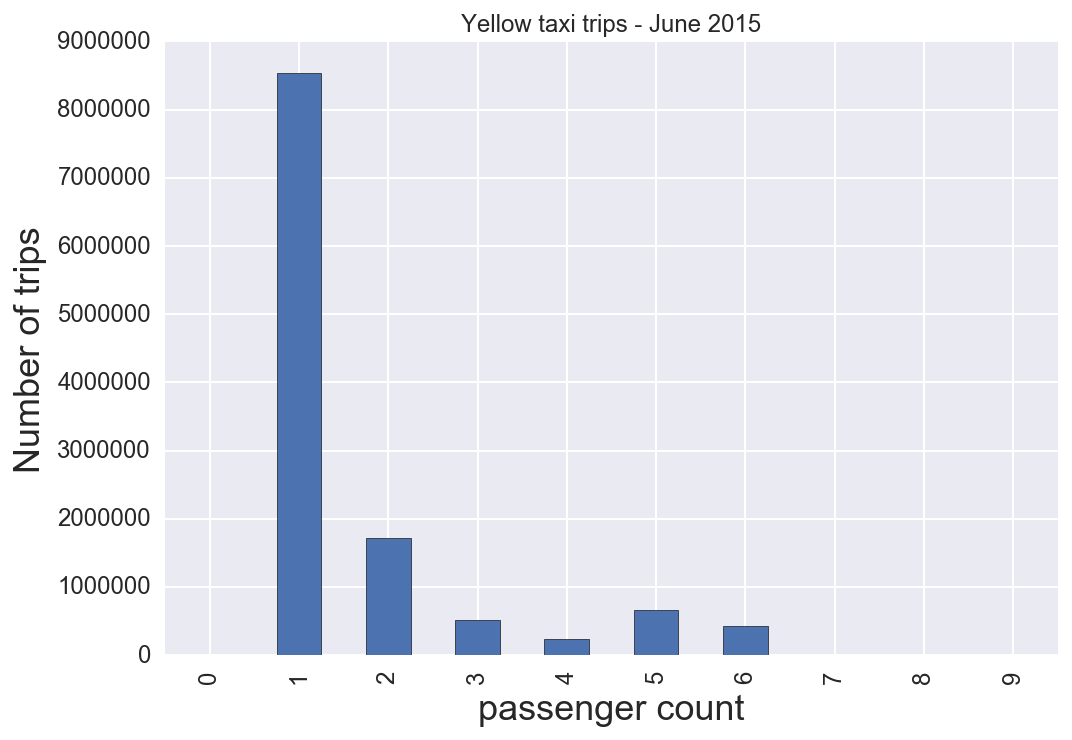

In [29]:
# A usual trip has 1 to 6 passengers. So, we can discard the others.
ax = df.groupby('passenger_count').size().plot(kind='bar')
ax.set_xlabel('passenger count', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
plt.title('Yellow taxi trips - June 2015')
ax.tick_params(labelsize=12)

passenger_count = ((df.passenger_count >= 1.0) & (df.passenger_count <= 6.0))
trip_time_in_secs = ((df.trip_time_in_secs > 0.0) & (df.trip_time_in_secs <= 3600.0))
trip_distance = ((df.trip_distance > 0.0) & (df.trip_distance <= 25.0))

df = df[passenger_count & trip_time_in_secs & trip_distance]

passenger_count = None
trip_time_in_secs = None
trip_distance = None
subtotal = None

Continuing with the attributes, it's the turn of the coordinates, longitude and latitude for pickups and dropoffs. By observing the above dataframe, we notice coordinates that don't even exist! For fix that, we can use only the coordinates satisfying the conditions in the following table:

|               | Min           | Max       |
| ------------- |:-------------:| ---------:|
| Latitude      | 40.459518     | 41.175342 |
| Longitude     | −74.361107    | −71,903083|

In [30]:
# eliminate outliers based on location
pickup_latitude = ((df.pickup_latitude >= 40.459518) & (df.pickup_latitude <= 41.175342))
pickup_longitude = ((df.pickup_longitude >= -74.361107) & (df.pickup_longitude <= -71.903083))
dropoff_latitude = ((df.dropoff_latitude >= 40.459518) & (df.dropoff_latitude <= 41.175342))
dropoff_longitude = ((df.dropoff_longitude >= -74.361107) & (df.dropoff_longitude <= -71.903083))

df = df[pickup_latitude & pickup_longitude & dropoff_latitude & dropoff_longitude]

pickup_latitude = None
pickup_longitude = None
dropoff_latitude = None
dropoff_longitude = None

Now, we would like to be able to subset the taxi data by the *neighborhoods* people were travelling to and from in order to discover any *trends* that may be there; thus, we create columns for *pickup and dropoff neighborhood* using geographic boundaries defined using Google maps.

In [31]:
# Make a tuple column for pickup and dropoff latitudes and longitudes
df['pickup_lat_long'] = list(zip(df.pickup_latitude, df.pickup_longitude))
df['dropoff_lat_long'] = list(zip(df.dropoff_latitude, df.dropoff_longitude))
### COMMENT: In Python 3, zip returns an iterator of tuples, like itertools.izip in Python2. 
### To get a list of tuples, use list(zip(foo, bar)). And to zip until both iterators are exhausted, 
## you would use itertools.zip_longest.

# Define the pickup neighborhood column
df['pickup_neighborhood'] = ['Upper East Side' if ((-73.93269 <= longitude <= -73.958506 and (-.400732*longitude + 11.120735 <= latitude <= 1.351248*longitude + 140.720423))
                               or (-73.958506 < longitude <= -73.955760 and (1.351248*longitude + 140.690003 <= latitude <= 1.351248*longitude + 140.720423)) 
                               or (-73.955760 < longitude <= -73.938250 and (1.351248*longitude + 140.690003 <= latitude <= -0.400732*longitude + 11.151410)))
                               else 'Upper West Side' if ((-73.996349 <= longitude <= -73.981929 and (-.437663*longitude + 8.388736 <= latitude <= 1.411006*longitude + 145.183292))
                               or (-73.981929 < longitude <= -73.971286 and (1.411006*longitude + 145.156835 <= latitude <= 1.411006*longitude + 145.183292)) 
                               or (-73.971286 < longitude <= -73.958669 and (1.411006*longitude + 145.156835 <= latitude <= -0.437663*longitude + 8.431736)))
                               else 'East Harlem' if ((-73.955810 <= longitude <= -73.941562 and (-.410514*longitude + 10.427000 <= latitude <= 1.364892*longitude + 141.729588))
                               or (-73.941562 < longitude <= -73.934009 and (1.364892*longitude + 141.701598 <= latitude <= 1.364892*longitude + 141.729588)) 
                               or (-73.934009 < longitude <= -73.927400 and (1.364892*longitude + 141.701598 <= latitude <= -2.870328*longitude - 171.397205)))
                               else 'Harlem' if ((-73.970920 <= longitude <= -73.949376 and (-.434274*longitude + 8.682696 <= latitude <= 1.335965*longitude + 139.629557))
                               or (-73.949376 < longitude <= -73.950406 and (1.335965*longitude + 139.590765 <= latitude <= 1.335965*longitude + 139.629557)) 
                               or (-73.950406 < longitude <= -73.933669 and (1.335965*longitude + 139.590765 <= latitude <= -.434274*longitude + 8.719664)))
                               else 'Washington Heights' if ((-73.952561 <= longitude <= -73.934450 and (-.405223*longitude + 10.868172 <= latitude <= 1.704239*longitude + 166.868290))
                               or (-73.934450 < longitude <= -73.938313 and (2.030519*longitude + 190.953417 <= latitude <= 1.704239*longitude + 166.868290)) 
                               or (-73.938313 < longitude <= -73.921147 and (2.030519*longitude + 190.953417 <= latitude <= -.405223*longitude + 10.898228)))
                               else 'Chelsea' if ((-74.012918 <= longitude <= -74.004936 and (-.425864*longitude + 9.225036 <= latitude <= 1.46181*longitude + 148.938269))
                               or (-74.004936 < longitude <= -73.996181 and (-.425864*longitude + 9.225036 <= latitude <= -.425864*longitude + 9.241076)) 
                               or (-73.996181 < longitude <= -73.987684 and (1.46181*longitude + 148.905703 <= latitude <= -.425864*longitude + 9.241076)))
                               else "Hell's Kitchen" if ((-74.005267 <= longitude <= -73.994023 and (-.455589*longitude + 7.041340 <= latitude <= 1.380893*longitude + 142.951146))
                               or (-73.994023 < longitude <= -73.993423 and (-.455589*longitude + 7.041340 <= latitude <= -.455589*longitude + 7.062455)) 
                               or (-73.993423 < longitude <= -73.982265 and (1.380893*longitude + 142.928930 <= latitude <= -.455589*longitude + 7.062455)))
                               else 'Midtown' if ((-73.993851 <= longitude <= -73.984495 and (-.401974*longitude + 11.008620 <= latitude <= 1.389750*longitude + 143.583485))
                               or (-73.984495 < longitude <= -73.981491 and (1.389750*longitude + 143.568415 <= latitude <= 1.389750*longitude + 143.583485)) 
                               or (-73.981491 < longitude <= -73.973080 and (1.389750*longitude + 143.568415 <= latitude <= -.401974*longitude + 11.029072)))
                               else 'Midtown East' if ((-73.984495 <= longitude <= -73.972908 and (-.425289*longitude + 9.268809 <= latitude <= 1.369121*longitude + 142.042124))
                               or (-73.972908 < longitude <= -73.966986 and (-.425289*longitude + 9.268809 <= latitude <= -.425289*longitude + 9.289603)) 
                               or (-73.966986 < longitude <= -73.959004 and (1.369121*longitude + 142.017172 <= latitude <= -.425289*longitude + 9.289603)))
                               else 'Murray Hill and Gramercy' if ((-73.996782 <= longitude <= -73.987684 and (-.398282*longitude + 11.265240 <= latitude <= 1.422401*longitude + 145.989923))
                               or (-73.987684 < longitude <= -73.971634 and (-.398282*longitude + 11.265240 <= latitude <= -.398282*longitude + 11.281685)) 
                               or (-73.971634 < longitude <= -73.963909 and (1.422401*longitude + 145.944136 <= latitude <= -.398282*longitude + 11.281685)))
                               else 'East Village' if ((-73.992711 <= longitude <= -73.989621 and (-.430977*longitude + 8.834987 <= latitude <= 3.283819*longitude + 283.702814))
                               or (-73.989621 < longitude <= -73.972626 and (-.430977*longitude + 8.834987 <= latitude <= -.430977*longitude + 8.846466)) 
                               or (-73.972626 < longitude <= -73.971511 and (3.283819*longitude + 283.635539 <= latitude <= -.430977*longitude + 8.846466)))
                               else 'West Village' if ((-74.014761 <= longitude <= -74.009354 and (-.391182*longitude + 11.778190 <= latitude <= 1.374746*longitude + 142.486385))
                               or (-74.009354 < longitude <= -74.003603 and (-.391182*longitude + 11.778190 <= latitude <= -.391182*longitude + 11.791224)) 
                               or (-74.003603 < longitude <= -73.996222 and (1.374746*longitude + 142.463195 <= latitude <= -.391182*longitude + 11.791224)))
                               else 'Greenwich Village' if ((-74.002925 <= longitude <= -73.996230 and (-.454489*longitude + 7.094597 <= latitude <= 1.359970*longitude + 141.369870))
                               or (-73.996230 < longitude <= -73.992711 and (-.454489*longitude + 7.094597 <= latitude <= -.454489*longitude + 7.106744)) 
                               or (-73.992711 < longitude <= -73.989792 and (3.498458*longitude + 299.584471 <= latitude <= -.454489*longitude + 7.106744)))
                               else 'Financial District' if ((-74.017118 <= longitude <= -74.012741 and (-.689918*longitude - 10.363466 <= latitude <= 3.348184*longitude + 288.525206))
                               or (-74.012741 < longitude <= -74.010166 and (-.689918*longitude - 10.363466 <= latitude <= -.689918*longitude - 10.345791)) 
                               or (-74.010166 < longitude <= -73.999351 and (3.348184*longitude + 288.471136 <= latitude <= -.689918*longitude - 10.345791)))
                               else 'Lower East Side' if ((-74.001139 <= longitude <= -73.992642 and (-.296245*longitude + 18.787784 <= latitude <= 2.520648*longitude + 227.241074))
                               or (-73.992642 < longitude <= -73.978223 and (-.296245*longitude + 18.787784 <= latitude <= -.296245*longitude + 18.804157)) 
                               or (-73.978223 < longitude <= -73.973759 and (2.520648*longitude + 227.180321 <= latitude <= -.296245*longitude + 18.804157)))
                               else 'Soho' if ((-74.017018 <= longitude <= -74.011096 and (-.313095*longitude + 17.540902 <= latitude <= 1.631911*longitude + 161.509288))
                               or (-74.011096 < longitude <= -74.001225 and (-.313095*longitude + 17.540902 <= latitude <= -.313095*longitude + 17.557262)) 
                               or (-74.001225 < longitude <= -73.992814 and (1.631911*longitude + 161.473729 <= latitude <= -.313095*longitude + 17.557262)))
                               else 'Central Park' if ((-73.981834 <= longitude <= -73.972994 and (-.423978*longitude + 9.401321 <= latitude <= 1.364612*longitude + 141.724251))
                               or (-73.972994 < longitude <= -73.957716 and (1.364612*longitude + 141.708678 <= latitude <= 1.364612*longitude + 141.724251)) 
                               or (-73.957716 < longitude <= -73.949133 and (1.364612*longitude + 141.708678 <= latitude <= -.423978*longitude + 9.443998)))
                               else 'New Jersey' if (latitude >= 1.691689*longitude + 165.960150)
                               else 'Brooklyn' if (-74.042158 <= longitude <= -73.858137 and latitude < 40.700187)
                               else 'Laguardia Airport' if (-73.889398 <= longitude <= -73.855924 and 40.761247 <= latitude <= 40.785557)
                               else 'JFK Airport' if (-73.833340 <= longitude <= -73.747166 and 40.629567 <= latitude <= 40.670202)
                               else 'Queens' if (-73.940543 <= longitude <= -73.724937 and 40.672374 <= latitude <= 40.766049)
                               else 'Other' for latitude, longitude in df['pickup_lat_long']]

# Define the dropoff neighborhood column
df['dropoff_neighborhood'] = ['Upper East Side' if ((-73.93269 <= longitude <= -73.958506 and (-.400732*longitude + 11.120735 <= latitude <= 1.351248*longitude + 140.720423))
                               or (-73.958506 < longitude <= -73.955760 and (1.351248*longitude + 140.690003 <= latitude <= 1.351248*longitude + 140.720423)) 
                               or (-73.955760 < longitude <= -73.938250 and (1.351248*longitude + 140.690003 <= latitude <= -0.400732*longitude + 11.151410)))
                               else 'Upper West Side' if ((-73.996349 <= longitude <= -73.981929 and (-.437663*longitude + 8.388736 <= latitude <= 1.411006*longitude + 145.183292))
                               or (-73.981929 < longitude <= -73.971286 and (1.411006*longitude + 145.156835 <= latitude <= 1.411006*longitude + 145.183292)) 
                               or (-73.971286 < longitude <= -73.958669 and (1.411006*longitude + 145.156835 <= latitude <= -0.437663*longitude + 8.431736)))
                               else 'East Harlem' if ((-73.955810 <= longitude <= -73.941562 and (-.410514*longitude + 10.427000 <= latitude <= 1.364892*longitude + 141.729588))
                               or (-73.941562 < longitude <= -73.934009 and (1.364892*longitude + 141.701598 <= latitude <= 1.364892*longitude + 141.729588)) 
                               or (-73.934009 < longitude <= -73.927400 and (1.364892*longitude + 141.701598 <= latitude <= -2.870328*longitude - 171.397205)))
                               else 'Harlem' if ((-73.970920 <= longitude <= -73.949376 and (-.434274*longitude + 8.682696 <= latitude <= 1.335965*longitude + 139.629557))
                               or (-73.949376 < longitude <= -73.950406 and (1.335965*longitude + 139.590765 <= latitude <= 1.335965*longitude + 139.629557)) 
                               or (-73.950406 < longitude <= -73.933669 and (1.335965*longitude + 139.590765 <= latitude <= -.434274*longitude + 8.719664)))
                               else 'Washington Heights' if ((-73.952561 <= longitude <= -73.934450 and (-.405223*longitude + 10.868172 <= latitude <= 1.704239*longitude + 166.868290))
                               or (-73.934450 < longitude <= -73.938313 and (2.030519*longitude + 190.953417 <= latitude <= 1.704239*longitude + 166.868290)) 
                               or (-73.938313 < longitude <= -73.921147 and (2.030519*longitude + 190.953417 <= latitude <= -.405223*longitude + 10.898228)))
                               else 'Chelsea' if ((-74.012918 <= longitude <= -74.004936 and (-.425864*longitude + 9.225036 <= latitude <= 1.46181*longitude + 148.938269))
                               or (-74.004936 < longitude <= -73.996181 and (-.425864*longitude + 9.225036 <= latitude <= -.425864*longitude + 9.241076)) 
                               or (-73.996181 < longitude <= -73.987684 and (1.46181*longitude + 148.905703 <= latitude <= -.425864*longitude + 9.241076)))
                               else "Hell's Kitchen" if ((-74.005267 <= longitude <= -73.994023 and (-.455589*longitude + 7.041340 <= latitude <= 1.380893*longitude + 142.951146))
                               or (-73.994023 < longitude <= -73.993423 and (-.455589*longitude + 7.041340 <= latitude <= -.455589*longitude + 7.062455)) 
                               or (-73.993423 < longitude <= -73.982265 and (1.380893*longitude + 142.928930 <= latitude <= -.455589*longitude + 7.062455)))
                               else 'Midtown' if ((-73.993851 <= longitude <= -73.984495 and (-.401974*longitude + 11.008620 <= latitude <= 1.389750*longitude + 143.583485))
                               or (-73.984495 < longitude <= -73.981491 and (1.389750*longitude + 143.568415 <= latitude <= 1.389750*longitude + 143.583485)) 
                               or (-73.981491 < longitude <= -73.973080 and (1.389750*longitude + 143.568415 <= latitude <= -.401974*longitude + 11.029072)))
                               else 'Midtown East' if ((-73.984495 <= longitude <= -73.972908 and (-.425289*longitude + 9.268809 <= latitude <= 1.369121*longitude + 142.042124))
                               or (-73.972908 < longitude <= -73.966986 and (-.425289*longitude + 9.268809 <= latitude <= -.425289*longitude + 9.289603)) 
                               or (-73.966986 < longitude <= -73.959004 and (1.369121*longitude + 142.017172 <= latitude <= -.425289*longitude + 9.289603)))
                               else 'Murray Hill and Gramercy' if ((-73.996782 <= longitude <= -73.987684 and (-.398282*longitude + 11.265240 <= latitude <= 1.422401*longitude + 145.989923))
                               or (-73.987684 < longitude <= -73.971634 and (-.398282*longitude + 11.265240 <= latitude <= -.398282*longitude + 11.281685)) 
                               or (-73.971634 < longitude <= -73.963909 and (1.422401*longitude + 145.944136 <= latitude <= -.398282*longitude + 11.281685)))
                               else 'East Village' if ((-73.992711 <= longitude <= -73.989621 and (-.430977*longitude + 8.834987 <= latitude <= 3.283819*longitude + 283.702814))
                               or (-73.989621 < longitude <= -73.972626 and (-.430977*longitude + 8.834987 <= latitude <= -.430977*longitude + 8.846466)) 
                               or (-73.972626 < longitude <= -73.971511 and (3.283819*longitude + 283.635539 <= latitude <= -.430977*longitude + 8.846466)))
                               else 'West Village' if ((-74.014761 <= longitude <= -74.009354 and (-.391182*longitude + 11.778190 <= latitude <= 1.374746*longitude + 142.486385))
                               or (-74.009354 < longitude <= -74.003603 and (-.391182*longitude + 11.778190 <= latitude <= -.391182*longitude + 11.791224)) 
                               or (-74.003603 < longitude <= -73.996222 and (1.374746*longitude + 142.463195 <= latitude <= -.391182*longitude + 11.791224)))
                               else 'Greenwich Village' if ((-74.002925 <= longitude <= -73.996230 and (-.454489*longitude + 7.094597 <= latitude <= 1.359970*longitude + 141.369870))
                               or (-73.996230 < longitude <= -73.992711 and (-.454489*longitude + 7.094597 <= latitude <= -.454489*longitude + 7.106744)) 
                               or (-73.992711 < longitude <= -73.989792 and (3.498458*longitude + 299.584471 <= latitude <= -.454489*longitude + 7.106744)))
                               else 'Financial District' if ((-74.017118 <= longitude <= -74.012741 and (-.689918*longitude - 10.363466 <= latitude <= 3.348184*longitude + 288.525206))
                               or (-74.012741 < longitude <= -74.010166 and (-.689918*longitude - 10.363466 <= latitude <= -.689918*longitude - 10.345791)) 
                               or (-74.010166 < longitude <= -73.999351 and (3.348184*longitude + 288.471136 <= latitude <= -.689918*longitude - 10.345791)))
                               else 'Lower East Side' if ((-74.001139 <= longitude <= -73.992642 and (-.296245*longitude + 18.787784 <= latitude <= 2.520648*longitude + 227.241074))
                               or (-73.992642 < longitude <= -73.978223 and (-.296245*longitude + 18.787784 <= latitude <= -.296245*longitude + 18.804157)) 
                               or (-73.978223 < longitude <= -73.973759 and (2.520648*longitude + 227.180321 <= latitude <= -.296245*longitude + 18.804157)))
                               else 'Soho' if ((-74.017018 <= longitude <= -74.011096 and (-.313095*longitude + 17.540902 <= latitude <= 1.631911*longitude + 161.509288))
                               or (-74.011096 < longitude <= -74.001225 and (-.313095*longitude + 17.540902 <= latitude <= -.313095*longitude + 17.557262)) 
                               or (-74.001225 < longitude <= -73.992814 and (1.631911*longitude + 161.473729 <= latitude <= -.313095*longitude + 17.557262)))
                               else 'Central Park' if ((-73.981834 <= longitude <= -73.972994 and (-.423978*longitude + 9.401321 <= latitude <= 1.364612*longitude + 141.724251))
                               or (-73.972994 < longitude <= -73.957716 and (1.364612*longitude + 141.708678 <= latitude <= 1.364612*longitude + 141.724251)) 
                               or (-73.957716 < longitude <= -73.949133 and (1.364612*longitude + 141.708678 <= latitude <= -.423978*longitude + 9.443998)))
                               else 'New Jersey' if (latitude >= 1.691689*longitude + 165.960150)
                               else 'Brooklyn' if (-74.042158 <= longitude <= -73.858137 and latitude < 40.700187)
                               else 'Laguardia Airport' if (-73.889398 <= longitude <= -73.855924 and 40.761247 <= latitude <= 40.785557)
                               else 'JFK Airport' if (-73.833340 <= longitude <= -73.747166 and 40.629567 <= latitude <= 40.670202)
                               else 'Queens' if (-73.940543 <= longitude <= -73.724937 and 40.672374 <= latitude <= 40.766049)
                               else 'Other' for latitude, longitude in df['dropoff_lat_long']]

At this stage, we believe that the data set is pretty much clean, and set up to analyze actual trends. 
This is *our dataframe* we begin to work with. 

## Predictive Task 

The predictive task that is being analyzed is the percentage of tip in relation to the total amount paid for taxi trips in New York City (NYC). The predictive task was chosen due to our curiosity of what factors causes people to tip higher percentages. Ultimately, this analysis can be used to assist taxi drivers in considering these factors in order to better understand their business and how they can maximize the tip received.

### Preparing the notebook 

In [32]:
import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
import math 
import random

It might be a good idea to actually plot the *geographic locations* of the taxi pickups and dropoffs in order to gain a better understanding of where taxi trips are most concentrated: 

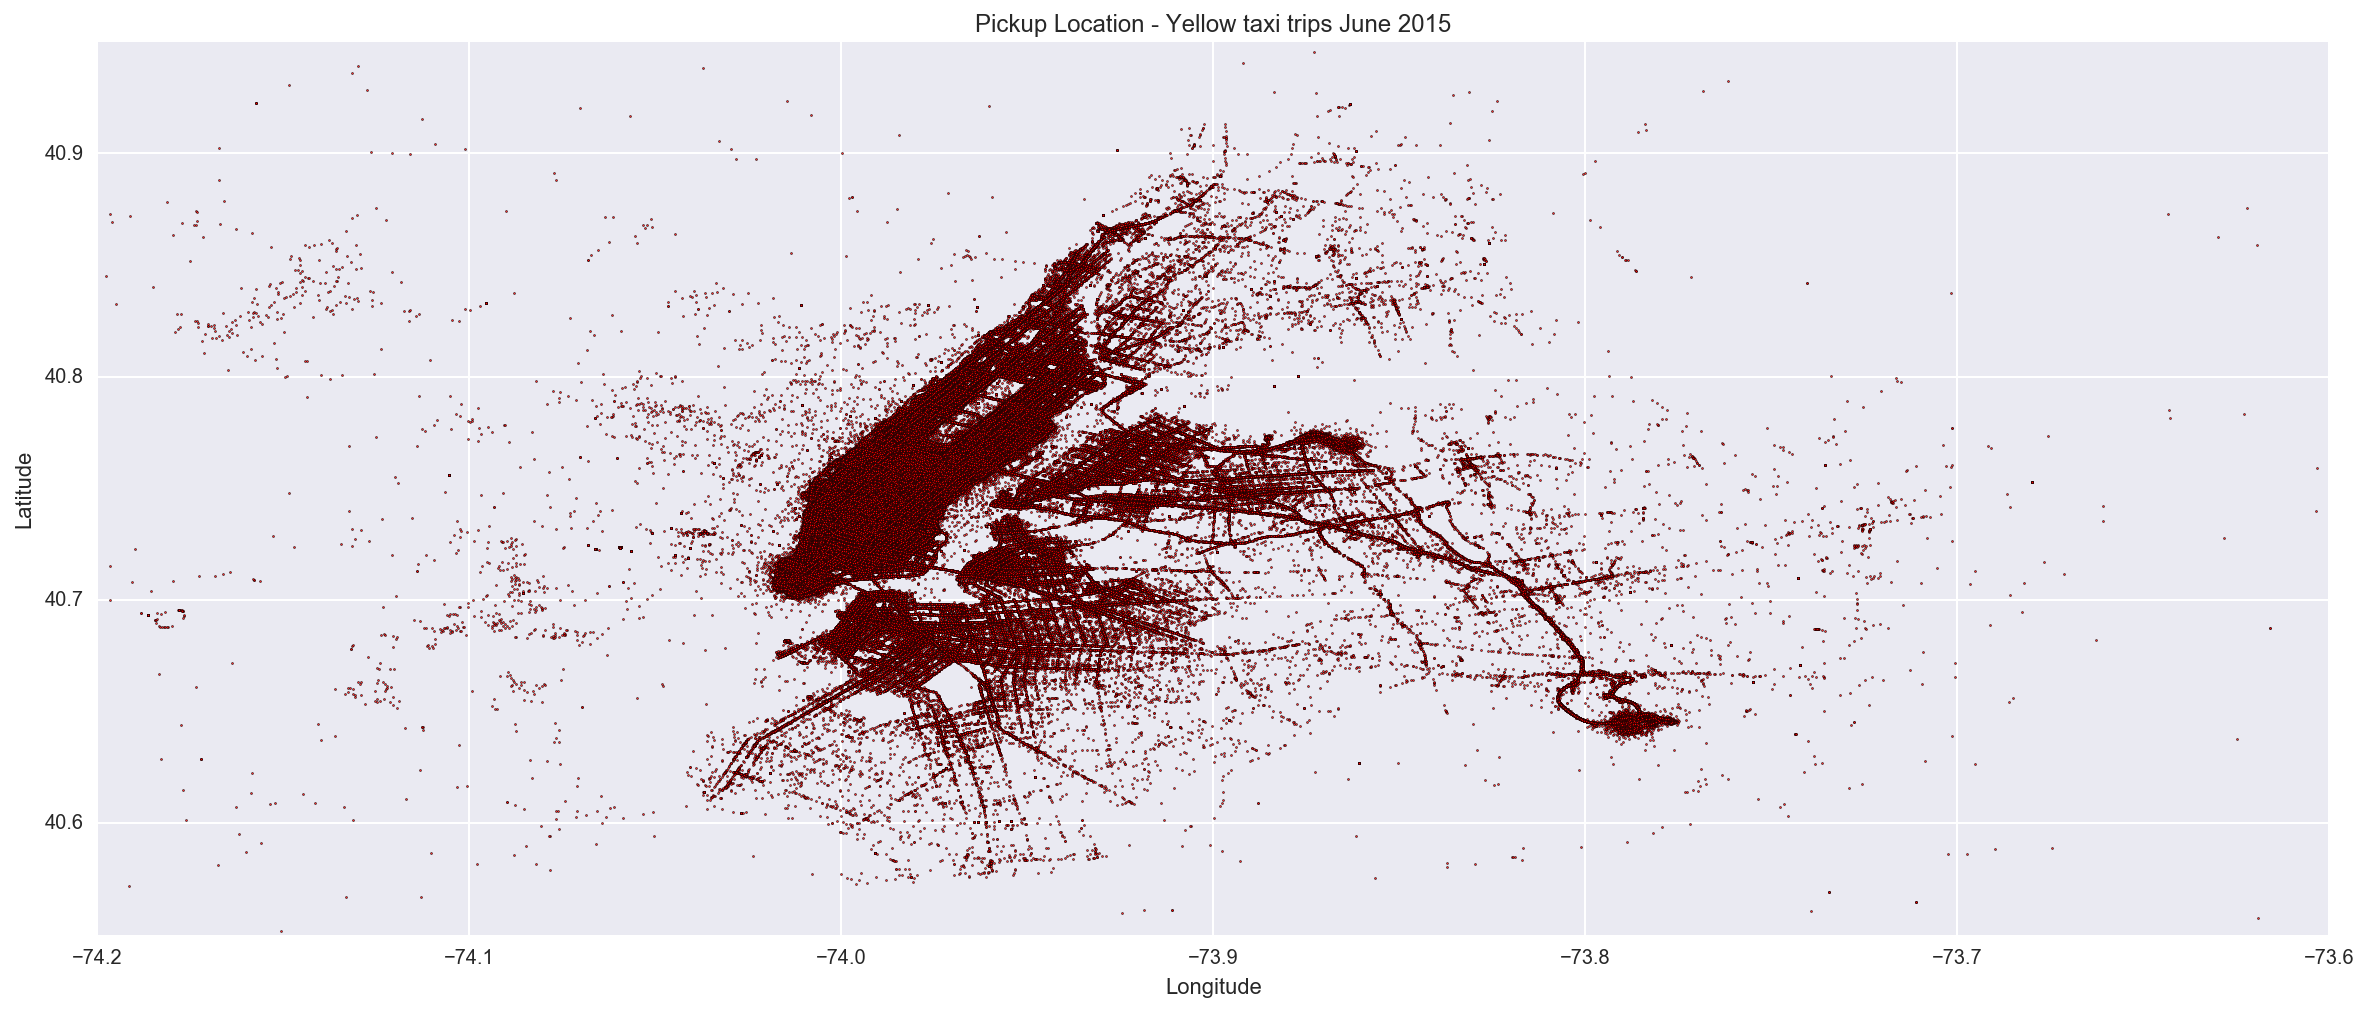

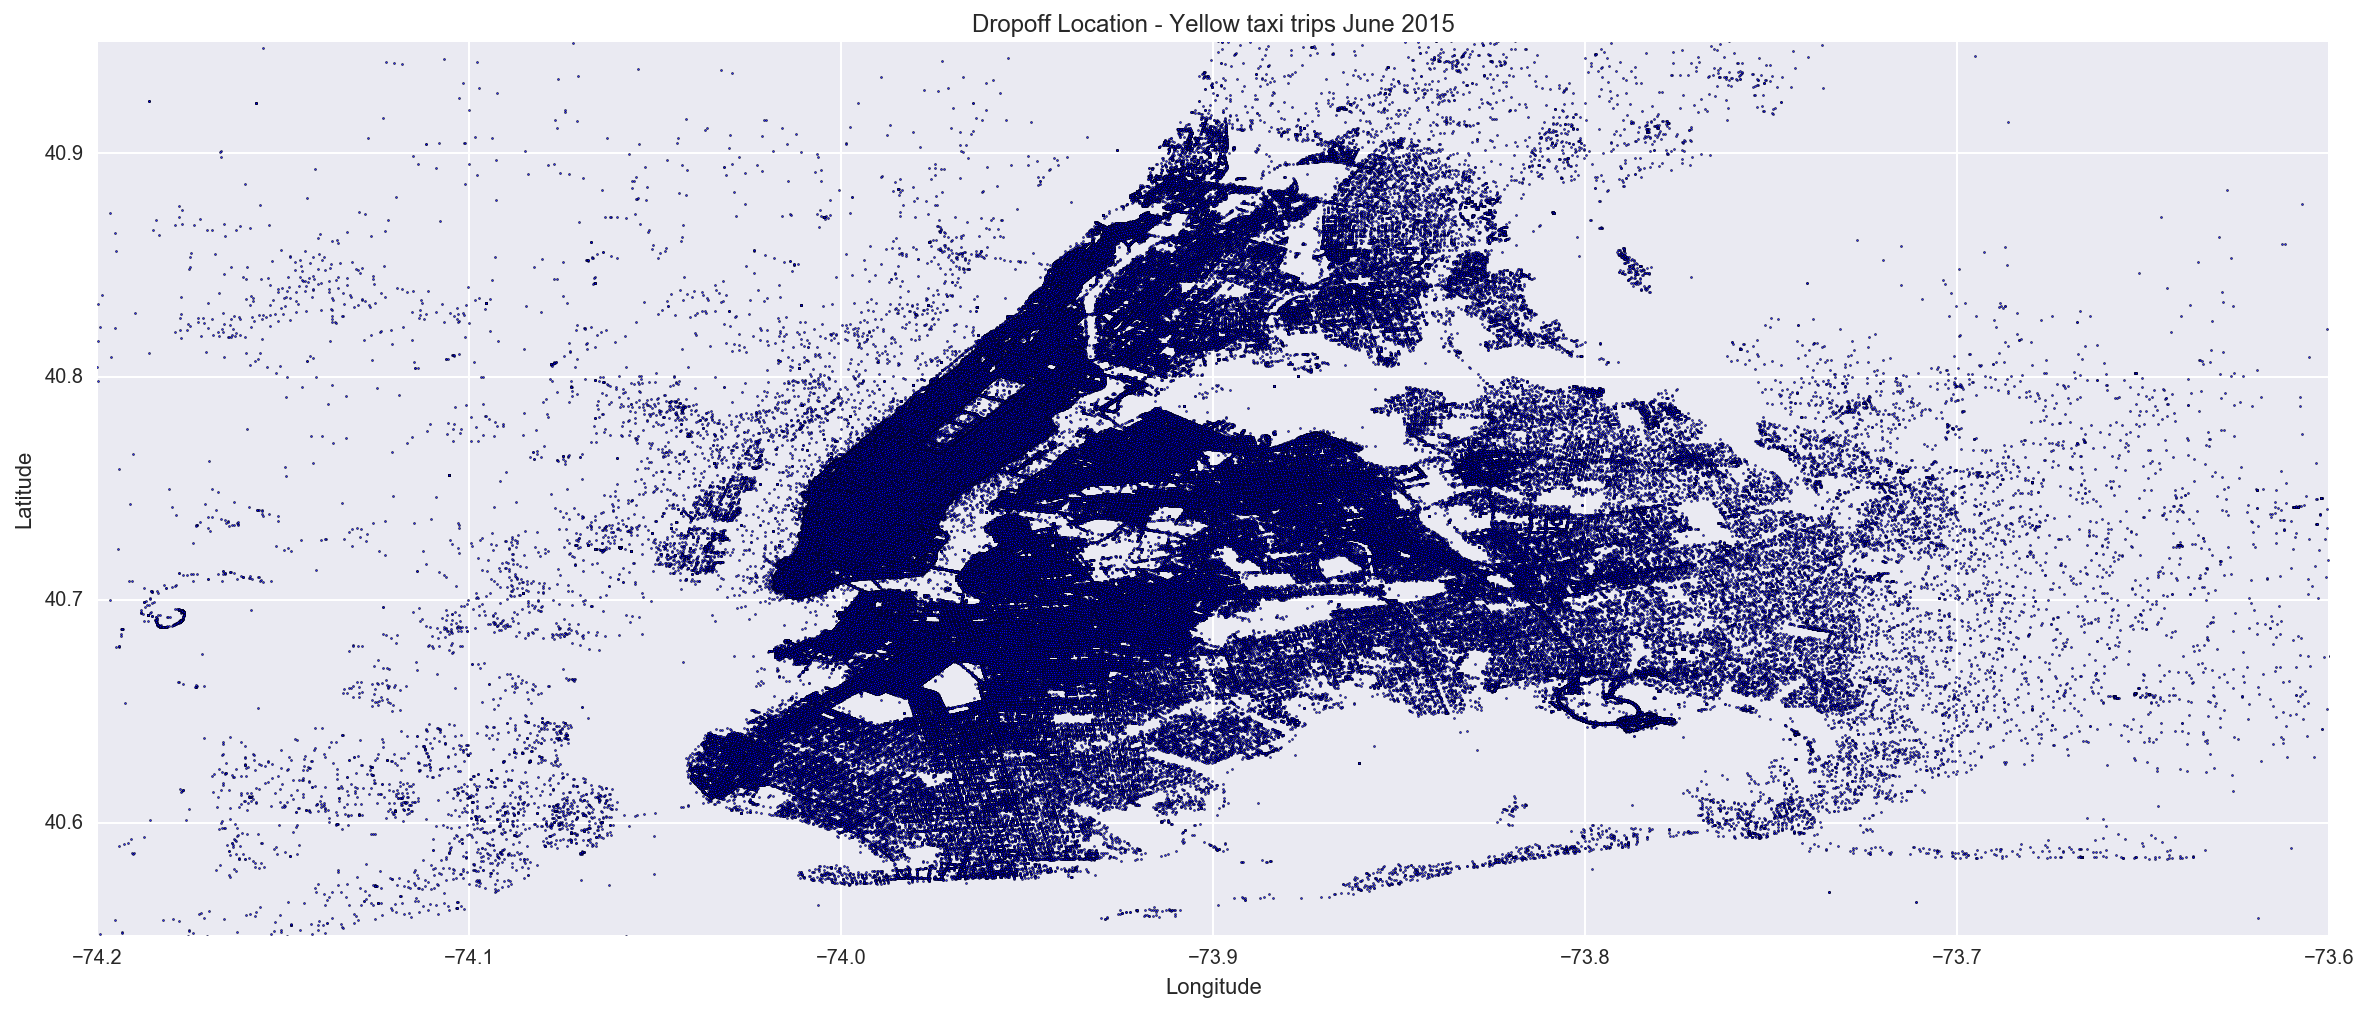

In [33]:
plt.figure(figsize =(20,8))
plt.scatter(df['pickup_longitude'],df['pickup_latitude'],s=1,alpha=0.8,c='r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup Location - Yellow taxi trips June 2015')
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 40.95)
plt.show()

plt.figure(figsize =(20,8))
plt.scatter(df['dropoff_longitude'],df['dropoff_latitude'],s=1,alpha=0.8,c='b')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dropoff Location - Yellow taxi trips June 2015')
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 40.95)
plt.show()

We see that the vast majority of trips are clustered in **Manhattan** and in two smaller spots outside the immediate vacinity of the city. Searching for the values of those latitudes and longitudes in Google Maps led us to discover that those smaller spots are reflective of the **Laguardia** and **JFK Airports**. As it turns out, `$52` is the flat rate for a trip from Manhattan to JFK Airport, explaining the spike in fare amount noted in the histogram below.
We then set about trying to figure out if we could determine any trends in the data that would suggest a high correlation between them and the amount of a tip. We assumed that trip time and trip distance would likely be the most highly correlated measurements.

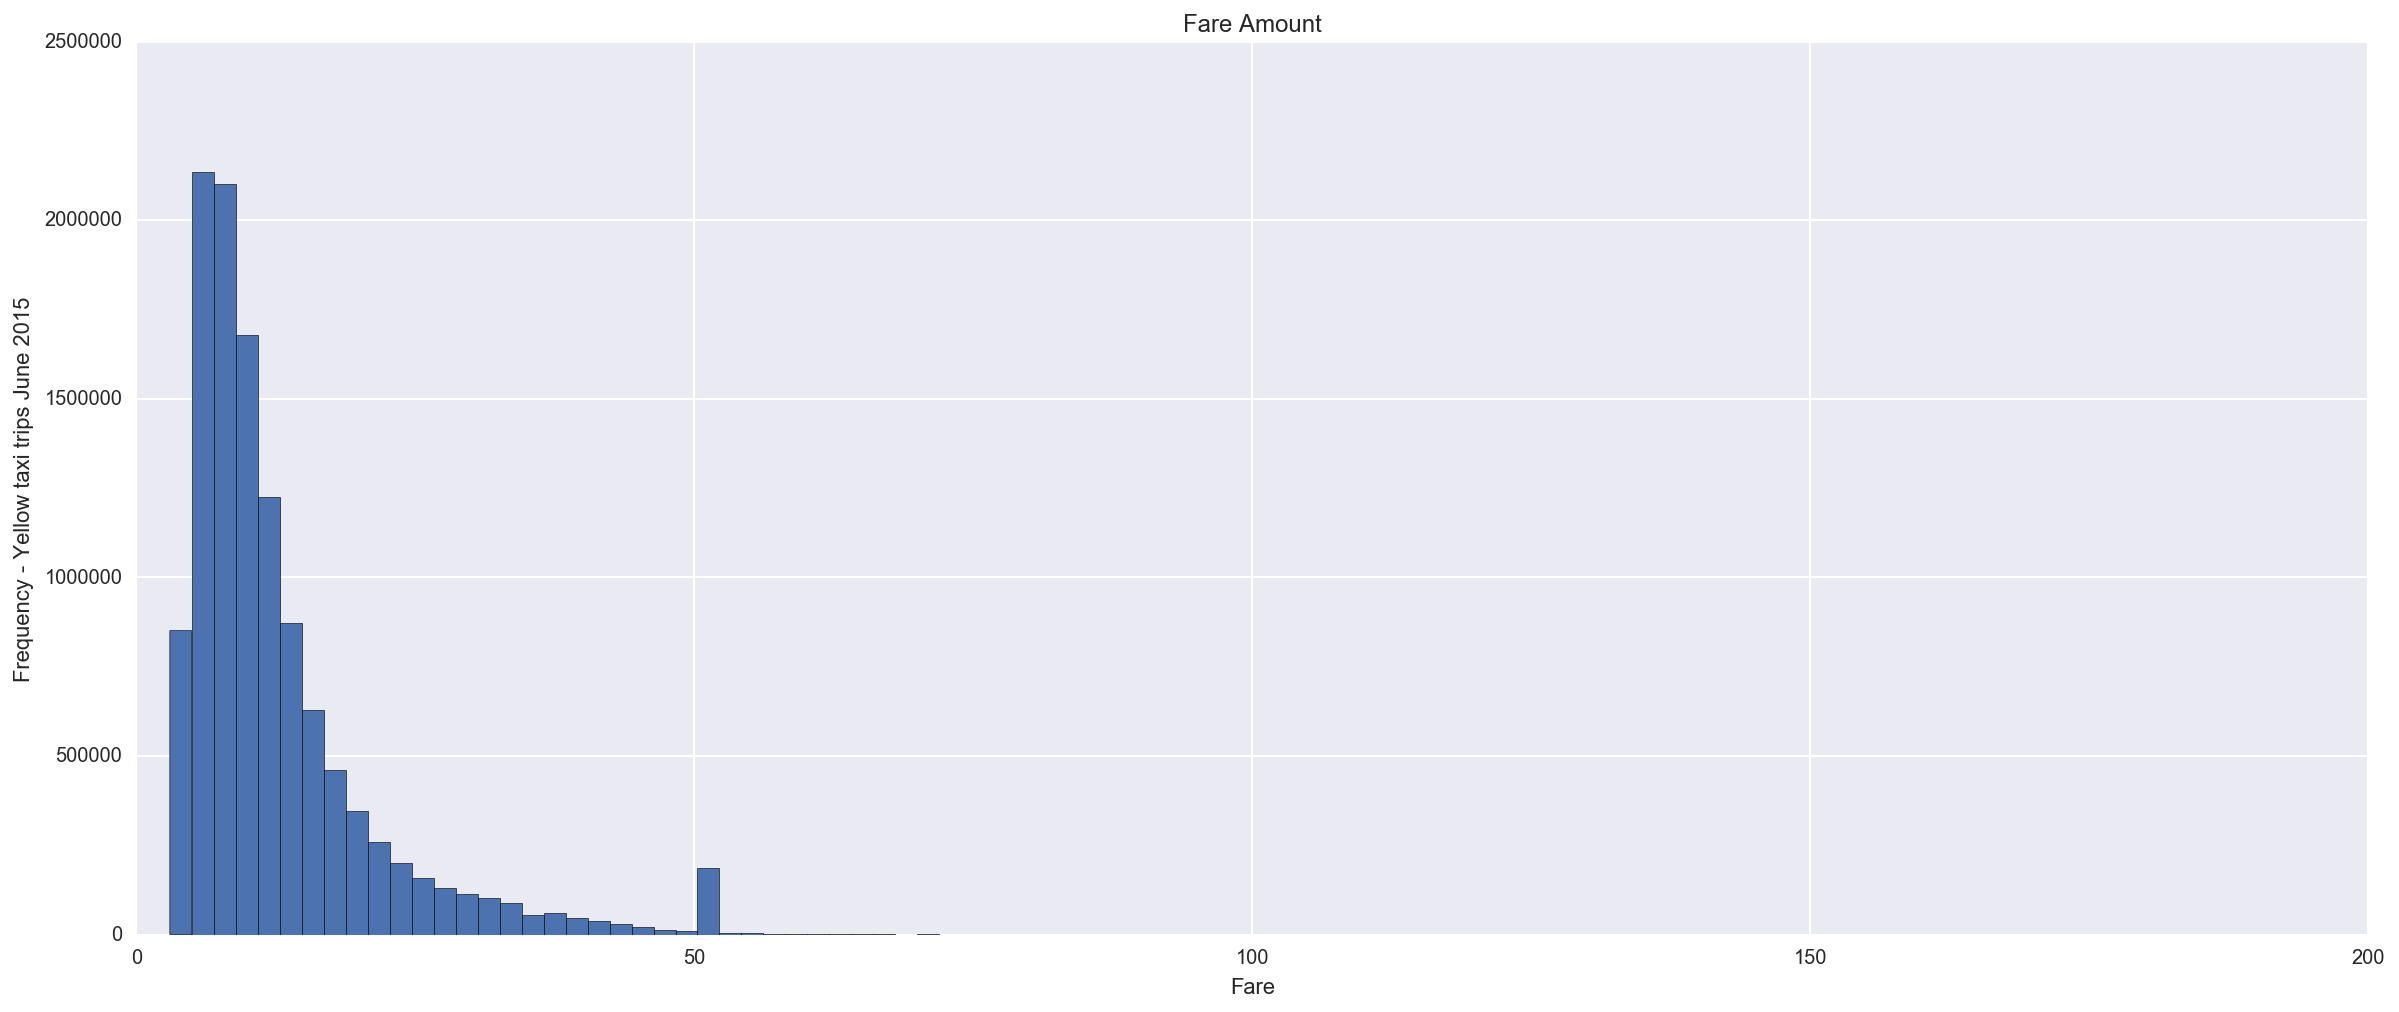

In [34]:
# plot a simple histogram
plt.figure(figsize =(20,8))
plt.hist(df['fare_amount'],bins=100)
plt.xlabel('Fare')
plt.ylabel('Frequency - Yellow taxi trips June 2015')
plt.title('Fare Amount')

We looked at tip as a percentage of the total cost of a trip, as clearly longer trips with higher fares will be correlated with higher tips.

In [35]:
df.percent_tip.mean()

0.12053754058288409

On average, the tip amount is roughly the `12%` of the fare amount. We decided to only look at trips where passengers paid card. This way we could be sure that the tip was accurately reported. We also decided that an interesting goal of this analysis might be to predict tip percentage a driver should have received based on the features of their trip.

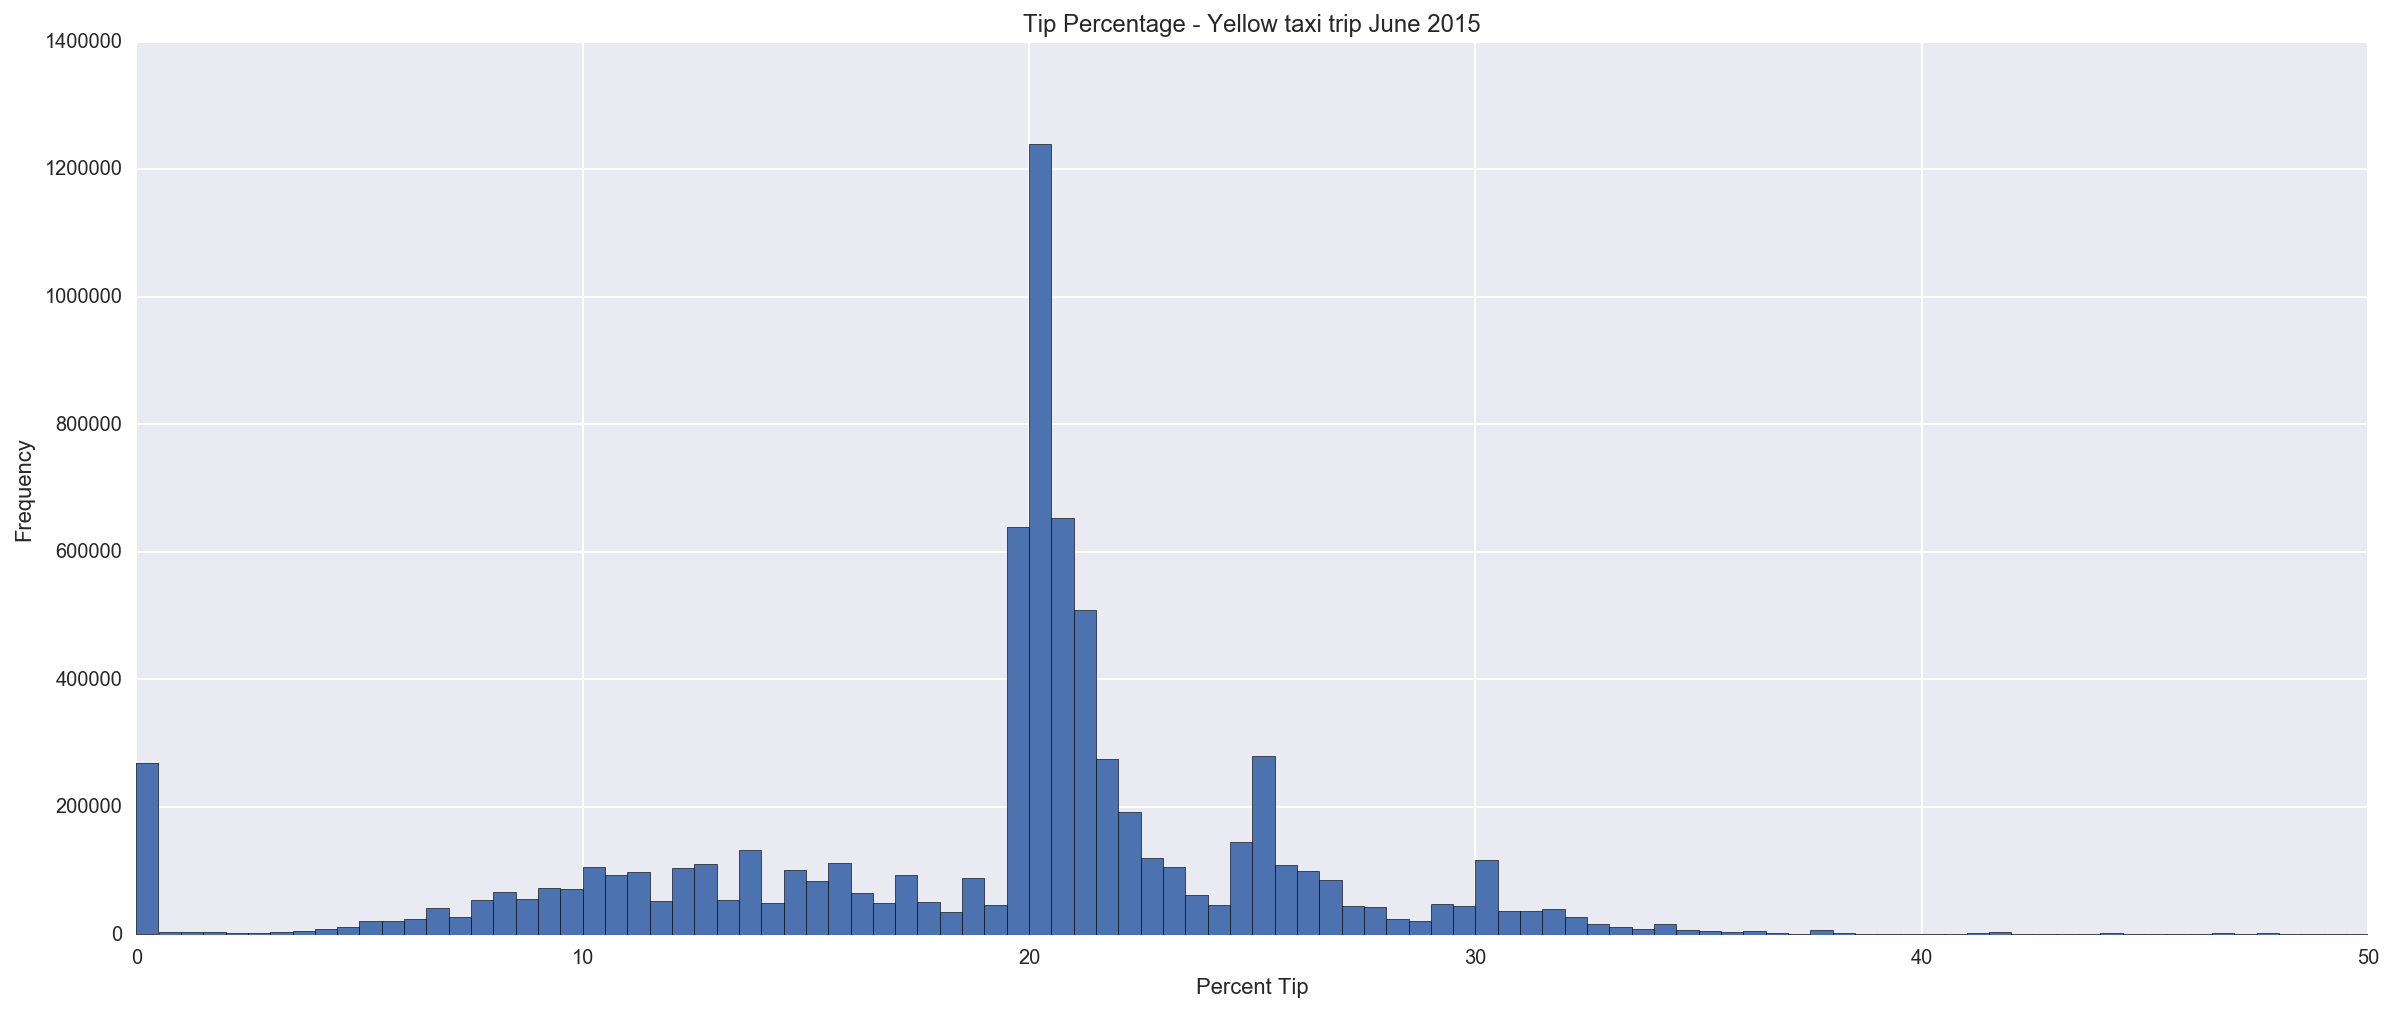

In [36]:
# create a subset for payments made with credit card
df = df[df['payment_type'] == 'CRD']

# plot the tip percentages
plt.figure(figsize=(20,8))
plt.hist(df['percent_tip']*100,bins=100)
plt.xlabel('Percent Tip')
plt.ylabel('Frequency')
plt.title('Tip Percentage - Yellow taxi trip June 2015')
plt.show()

This is now a much more reasonable histogram of tip percentage - the mode is clearly at 20%, with smaller peaks around 25%, 30%, 10% and 15%, all of which are preselected tips that can be chosen on the screen in the back of the taxi cab. The spike at 0% remains, but it is much more reasonable that in the original data set. Thus we began to look at other trends in the tip data before continuing to build a prediction based on this data.

### Tip or not To Tip, That is the Question!  

In this section, we study the taxi passengers' tipping behavior, which is a proxy for customer satisfaction or dissatisfaction toward their rides. We will show the readers that the tipping involves interesting and unusual human behavior/thinking. Firstly, we display the 2D maps for yellow taxis, showing the readers that the tipping percentages display a non-trivial fluctuation throughout the hours and weekdays.

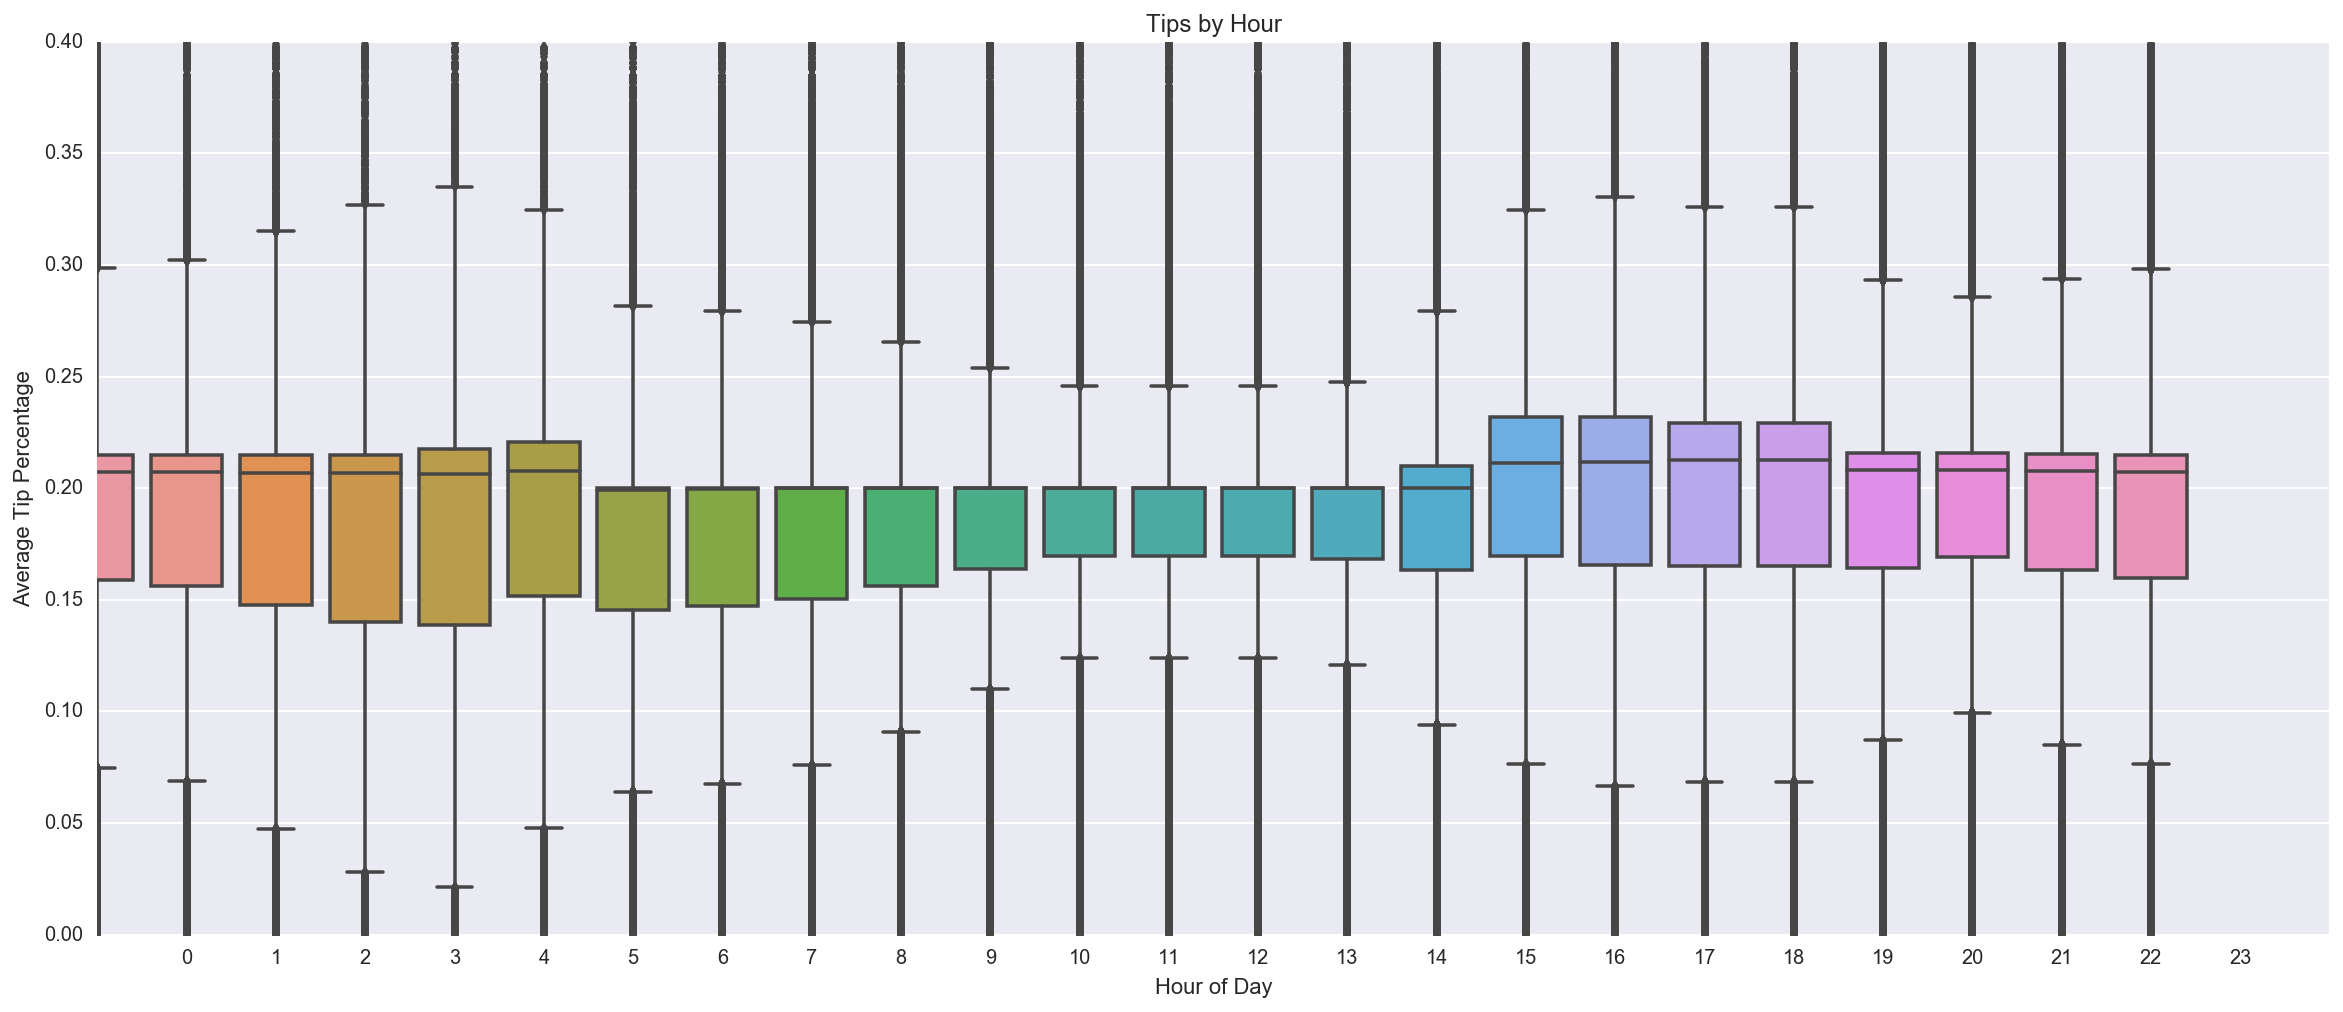

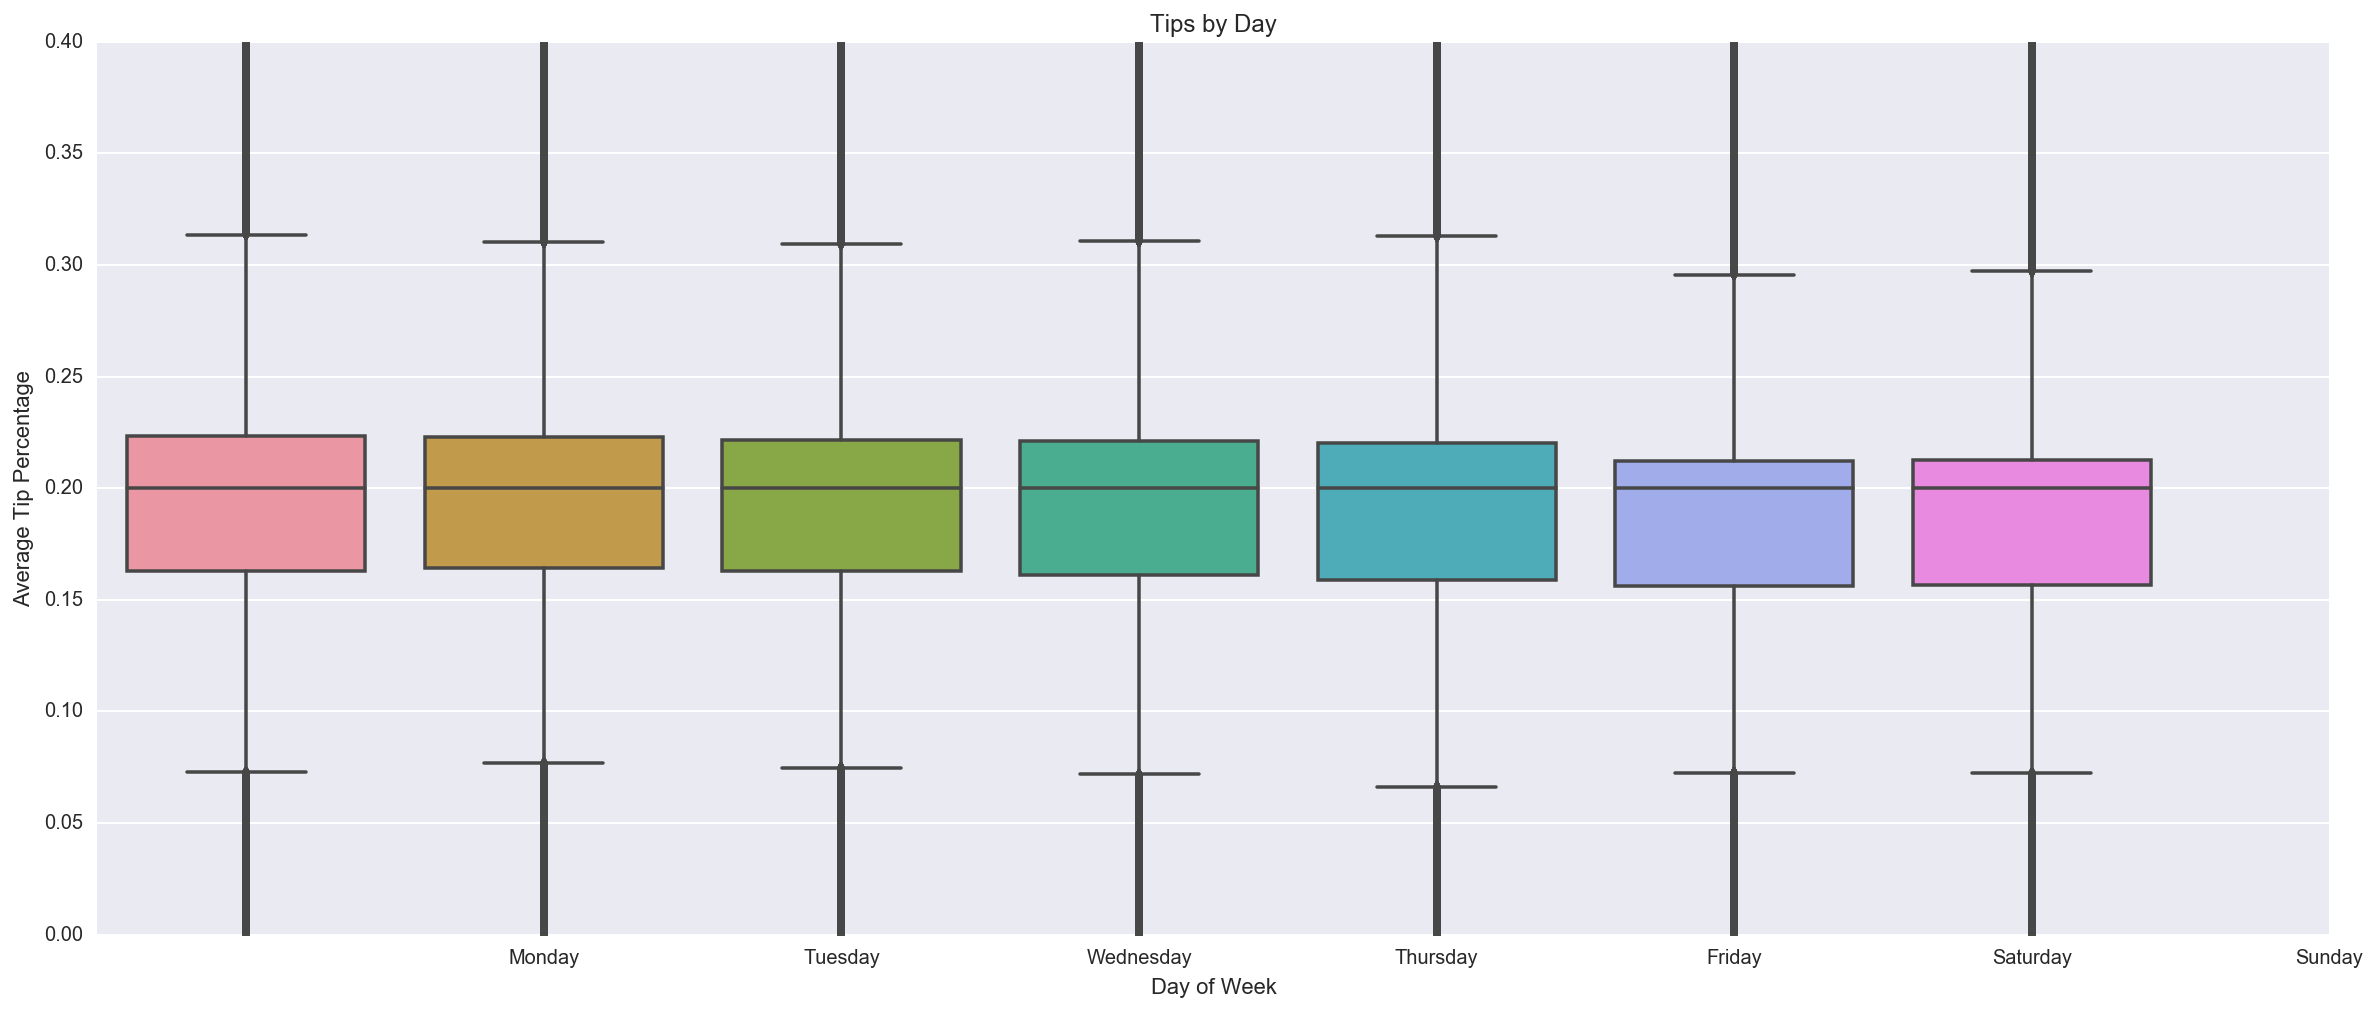

In [44]:
import calendar 
# Yellow Taxi Passengers' tipping varying over the course of the day

plt.figure(figsize=(20,8))
tips = []
for i in range(0,24): # 24 hours 
    data = df[df.hour == i]
    tips.append(data['percent_tip'])

sns.boxplot(data=tips)
### COMMENT: there have been some changes to the API for categorical plots.
### you just need to explicitly pass your list (tuple, technically) of arrays 
### to the data parameter:
plt.title('Tips by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Tip Percentage')
plt.xticks(range(1,25),range(0,24))
plt.xlim(0,25)
plt.ylim(0,0.4)
plt.show()

# plot tips over the course of the average week
plt.figure(figsize=(20,8))
tips = []
for i in range(0,7):
    data = df[df.weekday == i]
    tips.append(data['percent_tip'])
sns.boxplot(data=tips)
plt.title('Tips by Day')
plt.xlabel('Day of Week')
plt.ylabel('Average Tip Percentage')
plt.xticks(range(1,8),[calendar.day_name[i] for i in range(0,7)])
plt.ylim(0,0.4)
plt.show()

Clearly, there are no strong time-dependent trends in tip percentage - the average tip percentage remains fairly consistent over the course of the day, week. The variance of tip percentage is smallest in the early afternoon and reaches a peak around 4:00 AM/PM.  Now switching our focus from temporal to geographic trends, we looked at average tip percentage by pickup and dropoff neighborhood.

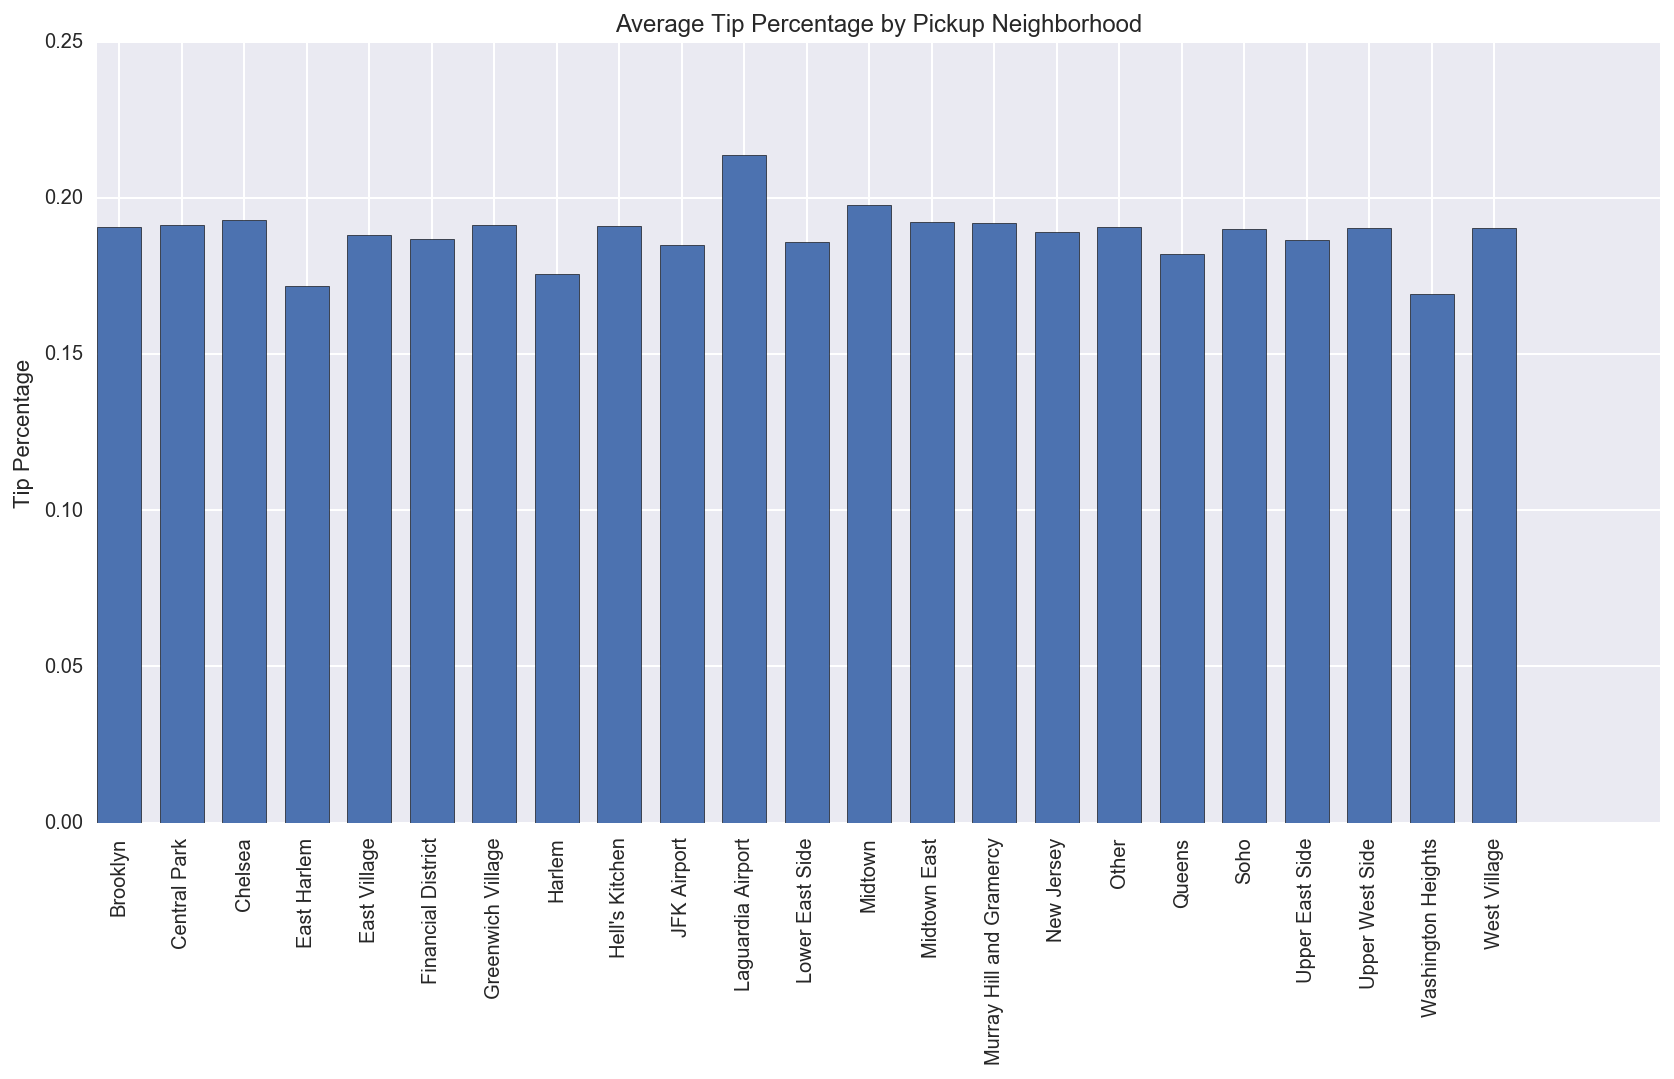

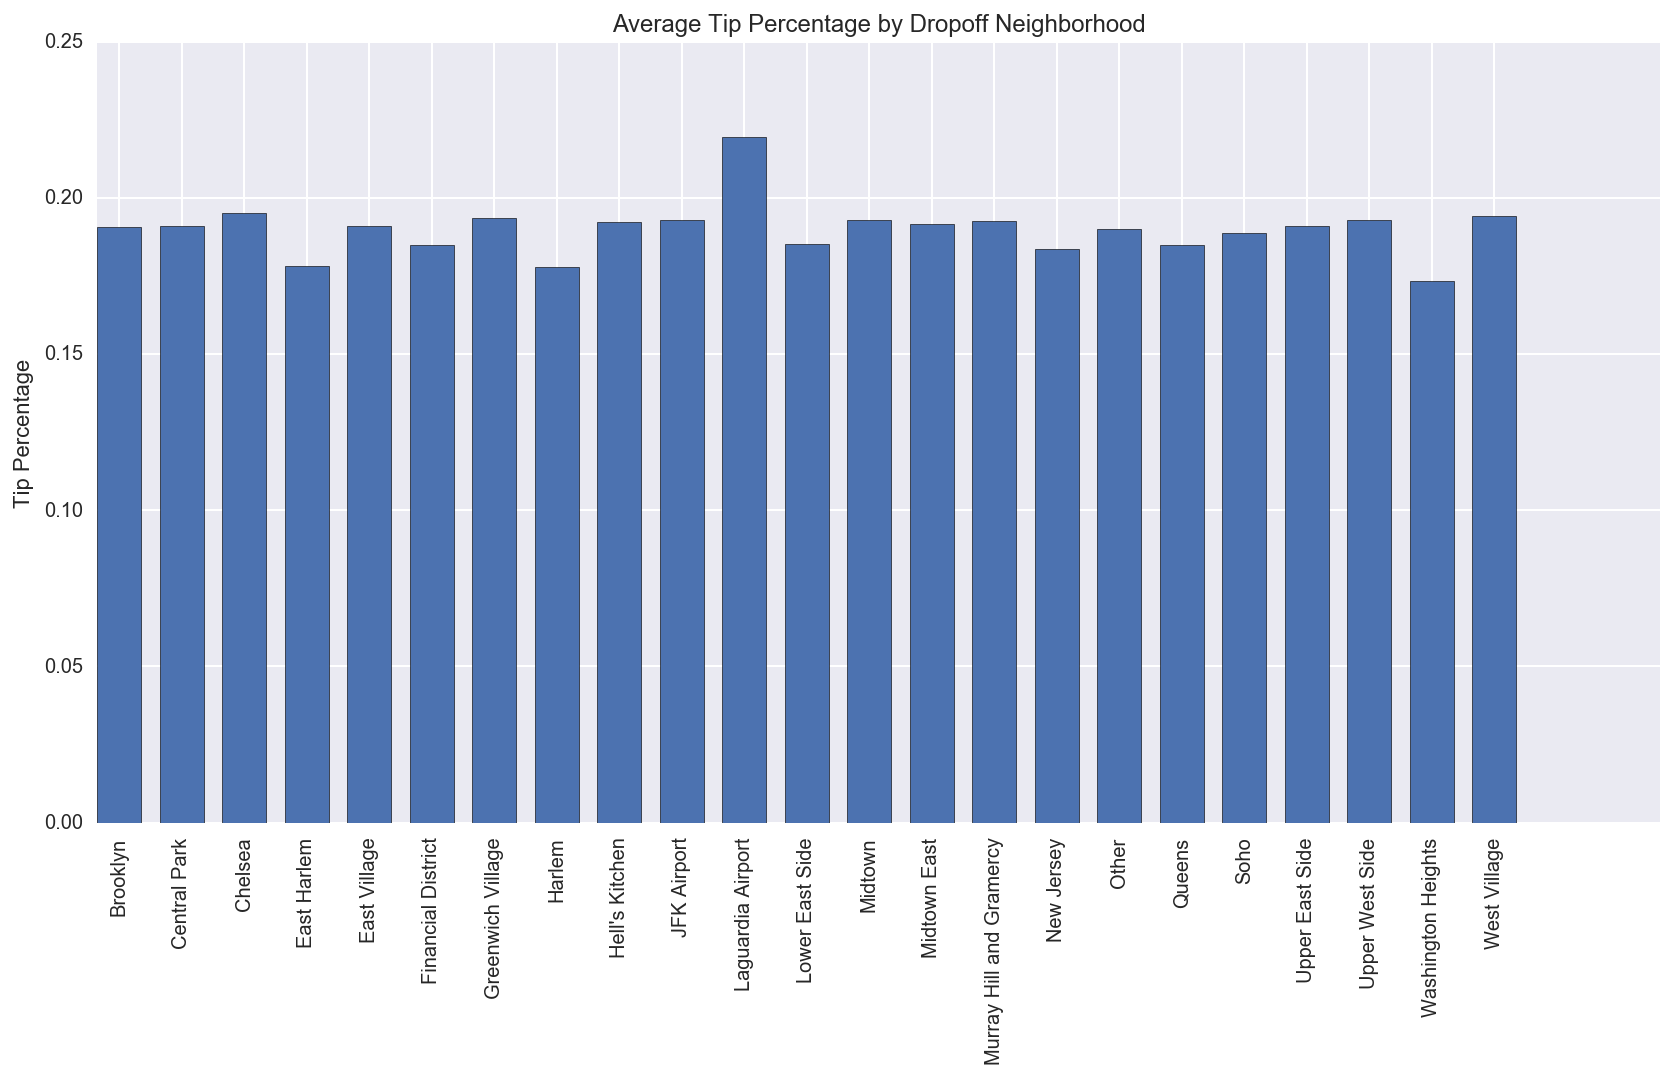

In [45]:
# aggregate data by pickup neighborhood
# to perform a computation on the grouped data.
# NOTE: Aggregation functions will not return the groups that 
# you are aggregating over if they are named columns, when as_index=True, the default. 
# The grouped columns will be the indices of the returned object.
# Passing as_index=False will return the groups that you are aggregating over, 
# if they are named columns.
grouped = df.groupby(['pickup_neighborhood'], as_index=False)
mean_pickup = grouped.aggregate(np.mean)

# plot tip percentage by pickup neighborhood
plt.figure(figsize=(20,8))
tip_percent = mean_pickup[['pickup_neighborhood', 'percent_tip']]
ind = np.arange(23) # 23 neighborhood 
heights = (tip_percent['percent_tip'])
plt.figure(figsize =(14,7))
plt.bar(ind, heights, width=0.70)
plt.ylabel('Tip Percentage')
plt.xticks(ind+0.70/2., (tip_percent['pickup_neighborhood']), rotation=90)
plt.title('Average Tip Percentage by Pickup Neighborhood')
plt.show()

# aggregate data by dropoff neighborhood
grouped = df.groupby(['dropoff_neighborhood'], as_index=False)
mean_dropoff = grouped.aggregate(np.mean)

# plot tip percentage by dropoff neighborhood
plt.figure(figsize=(20,8))
tip_percent = mean_dropoff[['dropoff_neighborhood', 'percent_tip']]
ind = np.arange(23)
heights = (tip_percent['percent_tip'])
plt.figure(figsize =(14,7))
plt.bar(ind, heights, width=0.70)
plt.ylabel('Tip Percentage')
plt.xticks(ind+0.70/2., (tip_percent['dropoff_neighborhood']), rotation=90)
plt.title('Average Tip Percentage by Dropoff Neighborhood')
plt.show()

Again, there do not seem to be any particularly significant trends, though there is certianly some variance - average tip percentage by region is more or less the same, though passengers travelling to and from Washington Heights and (East) Harlem tip considerably less than average.
Thus tip percentage does not appear to have much dependance on temporal or geographic factors, but perhaps there are other underlying trends that have to do with other trip features.

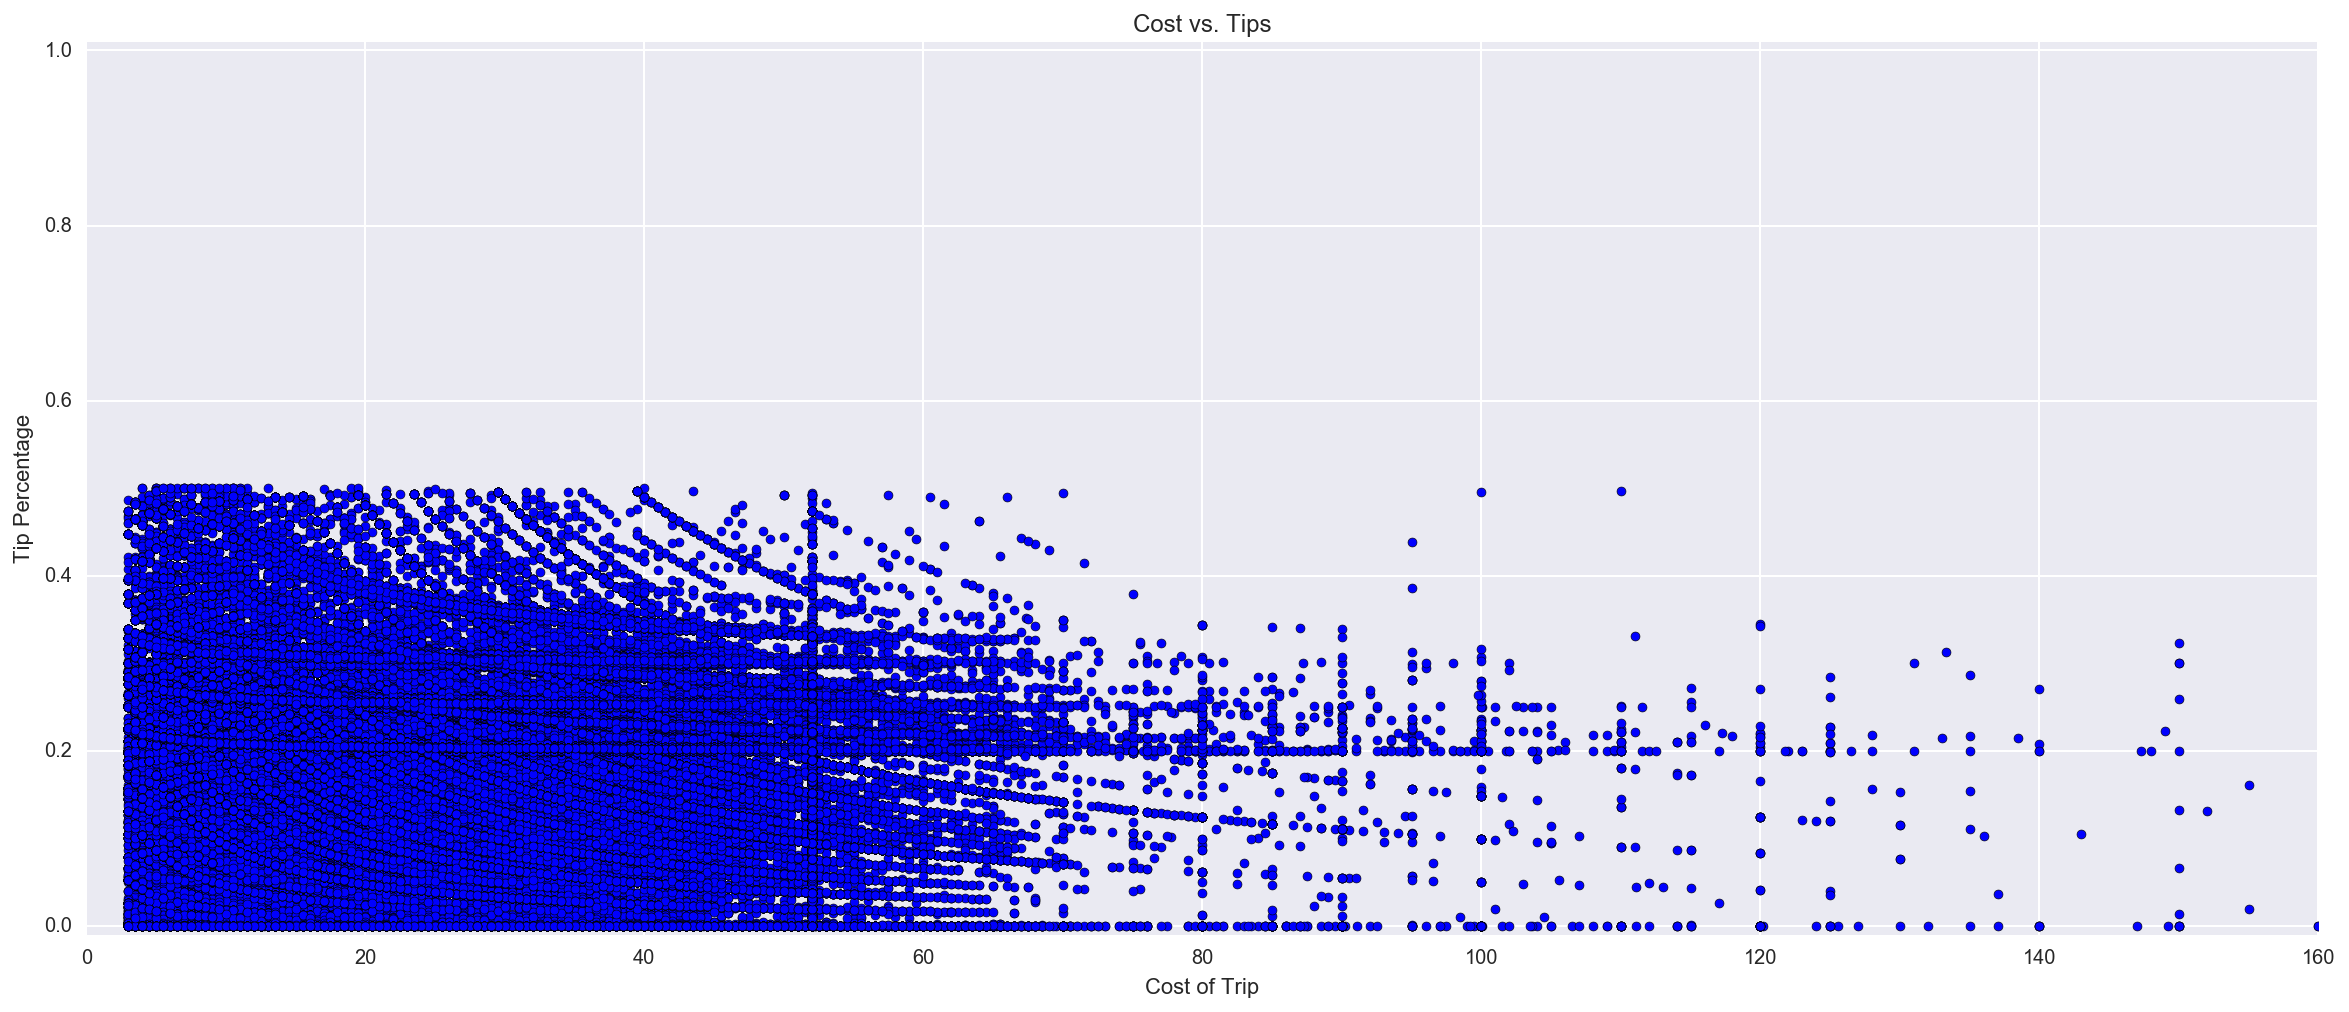

In [46]:
# plot cost of trip versus tip percentage
plt.figure(figsize=(20,8))
plt.scatter(df['fare_amount'], df['percent_tip'])
plt.xlabel('Cost of Trip')
plt.ylabel('Tip Percentage')
plt.xlim(0,160)
plt.ylim(-0.01,1.01)
plt.title('Cost vs. Tips')
plt.show()

Interestingly, as the cost of the trip increases, the tip percentage decreases fairly drastically, though we again see a consistent concentration of tip percentages around 20%, 25%, and 30% independent of trip cost. Thus as the cost of a trip increases, people become less willing to pay a high tip percentage.
Despite this apparent lack of trends, we decided it would be interesting to try to predict tip percentage using all available and relevant data, and perhaps some important correlations would emerge. We first used a *random forest* with 50 trees to do this.

In [ ]:
# Let's create a set of predictor variables and the tip percentages as the to predict
predictors = df[['trip_distance','trip_time_in_mins','speed','time',\
                        'weekday','passenger_count','fare_amount',\
                        'pickup_latitude','pickup_longitude','dropoff_latitude',\
                        'dropoff_longitude']]
X = predictors.as_matrix()
A = [round(a*100.0)for a in df['percent_tip']]
Y = np.asarray(A)

# get the feature names
features = [(a.replace('_', ' ')).title() for a in predictors.columns]

# split the data into a train and test set
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y, \
                                                                             test_size=0.33,\
                                                                             random_state=99)

# print dimensions to ensure it worked properly
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# initialize variables
optimal_trees = 0
best_performance = 0

for i in range(1,51): # number of trees 
    # initialize and train a classifier
    forest = RandomForestClassifier(n_estimators = i)
    forest.fit(X_train,Y_train)
    
    # get the relative importances
    importances = forest.feature_importances_
       
    # predict values on the test set
    Y_hat = forest.predict(X_test)
    
    # calculate accuracy of guesses
    performance = sklearn.metrics.accuracy_score(Y_test, Y_hat, normalize=True)
    
    if performance > best_performance:
        optimal_trees = i
        best_performance = performance
    
# use the optimal results
forest = RandomForestClassifier(n_estimators = optimal_trees)
forest.fit(X_train,Y_train)
importances = forest.feature_importances_
Y_hat = forest.predict(X_test)
performance = sklearn.metrics.accuracy_score(Y_test, Y_hat, normalize=True)

print('The Random Forest Classifier is ' + str(performance*100.0) +\
      '% accurate in predicting tip percentage with ' + str(optimal_trees) + ' trees.')
    
#plot the results
plt.figure(figsize=(20,8))
ind = np.arange(len(features))
plt.bar(ind,importances, width=0.70)
plt.xticks(ind+0.70/2, features, rotation = 90)
plt.title('Relative Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

(4999074, 11) (2462231, 11) (4999074,) (2462231,)


**NOTE: at the moment time the Random Forest algorithm is still running... so not possible to me to check the results**  Presumably, the distance, time, and speed of the trip are important features in predicting tip percentage, which makes sense given a person might be more generous when taking a fast rather than slow trip. Without the results of my rune, **at the moment** we are not able to predict tip percentage fairly accurately, considering this number ranges from 0 to 100. In order to increase the accuracy of the predicition, we decided to classify tip percentages as *'good' (1) or 'bad' (0)*, as this is all that is really necessary to determine whether a taxi driver is committing fraud or not.

In [ ]:
df['tip_class'] = [0 if a < 0.1 else 1 for a in df['percent_tip']]

# create a set of predictor variables and the tip percentages to predict
predictors = df[['trip_distance','trip_time_in_mins','speed','time',\
                   'weekday','passenger_count','fare_amount',\
                   'pickup_latitude','pickup_longitude','dropoff_latitude',\
                   'dropoff_longitude']]

X = predictors.as_matrix()
Y = df['tip_class'].as_matrix()

# get the feature names
features = [(a.replace('_', ' ')).title() for a in predictors.columns]

# split the data into a train and test set
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y, \
                                                                             test_size=0.33,\
                                                                             random_state=99)

# print dimensions to ensure it worked properly
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# initialize variables
optimal_trees = 0
best_performance = 0

for i in range(1,51): # 50 trees 
    # initialize and train a classifier
    forest = RandomForestClassifier(n_estimators = i)
    forest.fit(X_train,Y_train)
    
    # get the relative importances
    importances = forest.feature_importances_
       
    # predict values on the test set
    Y_hat = forest.predict(X_test)
    
    # calculate accuracy of guesses
    performance = sklearn.metrics.accuracy_score(Y_test, Y_hat, normalize=True)
    
    if performance > best_performance:
        optimal_trees = i
        best_performance = performance
    
# use the optimal results
forest = RandomForestClassifier(n_estimators = optimal_trees)
forest.fit(X_train,Y_train)
importances = forest.feature_importances_
Y_hat = forest.predict(X_test)
performance = sklearn.metrics.accuracy_score(Y_test, Y_hat, normalize=True)

print('The Random Forest Classifier is ' + str(performance*100.0) \
      + '% accurate in predicting tip class with ' + str(optimal_trees) + ' trees.')

**Waiting for a result, hopefully a very good accuracy in predicting wheter a tipp will be good or bad**

# Conclusions

When we think of how a tip is evaluated, we generally assess the person for the quality of their service. This for the most part is intuitively true, but when we look deeper we find that it is not the only factor in play. In the case of New York City's taxi drivers, location and tipe could both play a role in determining how much of a tip they receive.  We want to help the drivers, so we created a a sort of heatmap for the drivers which displayed which areas of pickup would generate the most tips. As for prediction, in the next steps we will focused on creating a prediction model for the taxi's base fare (instead of tip) based on time, date, and location; this would help passengers get a predicted fare based on where they wanted to go and when. While predicting fare, we think it might be useful as well to discover traffic patterns by way of predicting the speed of a taxi since if we could predict the speed of the taxi it could aid us in predicting the fare.